----
<h1 align="center"><span style='font-family:Georgia'> G-Research Crypto Forecasting </span></h1>

---

### Proplem Statement
Using historical cryptocurrency trading data with the aim of building time series forecasting models. General exploratory data analysis is performed to gain an overview of the full dataset and prepare the data for modeling. Specific preprocessing and analysis is then done on the Bitcoin subset of the data to characterize the time series and identify appropriate models. An **ARIMA** model is chosen as the traditional baseline model. Several neural network time series models are then evaluated on the Bitcoin data, including **DLinear**, **NLinear**, **Informer**, **FEDformer** and **PatchTST**, to investigate their performance for forecasting compared to the ARIMA baseline. 

By exploring both traditional and neural network time series models, this work aims to identify the best approach for 15-minute ahead forecasting of  the Bitcoin price move (net of market trends) over the next 15 minutes.

### Dataset Description

- **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
- **Asset_ID**: TThis column contains an ID number that corresponds to a specific cryptocurrency. For example, an Asset_ID of 1 corresponds to Bitcoin. A mapping from Asset_ID to the name of the cryptocurrency can be found in a separate file called `asset_details.csv`.
- **Count**: Total number of trades in the time interval (last minute).
- **Open**: Opening price of the time interval (in USD).
- **High**: Highest price reached during time interval (in USD).
- **Low**: Lowest price reached during time interval (in USD).
- **Close**: Closing price of the time interval (in USD).
- **Volume**: The quantity of the cryptocurrency that was bought or sold during the minute of trading activity represented by the corresponding timestamp, measured in USD.
- **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
- **Target**: This column contains the residual log-returns for the cryptocurrency over a 15-minute horizon. Residual log-returns are a way of measuring the percentage change in the price of an asset over a given time period, relative to some baseline. The Target column in this dataset represents the residual log-returns for a 15-minute period starting from the minute represented by the corresponding timestamp.

Additional information about cryptocurrencies include:

- **Asset_ID** : An ID code for the cryptocurrency.
- **Asse_Name** : The real name of the cryptocurrency associated to Asset_ID.
- **Weight** : The weight that the cryptocurrency associated to Asset_ID receives in the evaluation metric.

#### **The Evaluation Criteria**

- **MAE (Mean Absolute Error)** - The average magnitude of the errors in the predictions and gives an idea of the accuracy of the predictions.
- **MAPE (Mean Absolute Percentage Error)** - The average magnitude of the percentage error, useful to nullify the effect of different scales in values.
- **MSE (Mean Squared Error)** - The average of the square of the errors. MSE is more sensitive to large errors compared to MAE.

**So in summary, a good model will have:**
- Low MAE, MAPE and MSE

---
## Notebook Content
The notebook contains the following content:

### (1) EDA
This section of the notebook performs exploratory data analysis (EDA) on the whole dataset (`train.csv`). This includes:
1. Check Data Quality
2. Explore Some Features
3. Feature Engineering
4. Split Dataset to 14 sets

### (2) Working on Bitcoin dataset
This section of the notebook loads the Bitcoin dataset and performs data preprocessing and EDA on the dataset. This includes:
1. Load Bitcoin dataset
2. Data Preprocessing and EDA on Bitcoin dataset
    - Decomposition 
    - Moving averages window
    - Exponential Smoothing
    - Stationarity
    
3. Choosing ARIMA as a basline model from the traditional models.
    
4. Evaluating the dataset on DLinear, NLinear, Informer, FEDformer, and PatchTST.
    
### (3) Analysis the Results

---
# Setup
---

In [1]:
!pip install opendatasets

  Using cached opendatasets-0.1.22-py3-none-any.whl (15 kB)
  Using cached kaggle-1.5.15-py3-none-any.whl
  Using cached python_slugify-8.0.1-py2.py3-none-any.whl (9.7 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


In [2]:
!pip install torchscan #from torchscan import summary

  Using cached torchscan-0.1.2-py3-none-any.whl (30 kB)
  Using cached torch-1.13.1-cp39-cp39-manylinux1_x86_64.whl (887.4 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is inco

**Import needed dependencies**

In [5]:
import os
import time
import pandas as pd
import numpy as np
import random
import itertools
import opendatasets as od 

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
import statsmodels.tsa.arima.model
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error 

import torch

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Allocate color palette**

In [5]:
plt.style.use('seaborn-white')
%matplotlib inline

RdBu_colors  = sns.color_palette("RdBu",15)
pastel_colors  = sns.color_palette("pastel",15)
blind_colors = sns.color_palette("colorblind", 15)
sns.set_theme(style="whitegrid", palette=blind_colors)

blind_colors
RdBu_colors
pastel_colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

[(0.5884659746251442, 0.05905420991926182, 0.1510957324106113),
 (0.7340253748558246, 0.16608996539792387, 0.20261437908496732),
 (0.8226066897347174, 0.34325259515570933, 0.28627450980392155),
 (0.8991926182237601, 0.5144175317185697, 0.4079200307574009),
 (0.9617070357554787, 0.6761245674740484, 0.546943483275663),
 (0.9838523644752019, 0.8089965397923875, 0.7167243367935409),
 (0.9829296424452134, 0.9018838908112264, 0.8542099192618224),
 (0.9657054978854287, 0.9672433679354094, 0.9680891964628989),
 (0.8722029988465976, 0.9229527104959632, 0.9508650519031142),
 (0.7517877739331029, 0.8635909265667053, 0.9217993079584775),
 (0.5967704728950406, 0.7848519800076895, 0.8775086505190313),
 (0.4085351787773935, 0.6687427912341408, 0.8145328719723184),
 (0.24183006535947713, 0.5487889273356401, 0.750557477893118),
 (0.15816993464052287, 0.43806228373702427, 0.6939638600538255),
 (0.08419838523644753, 0.31280276816609, 0.5534025374855824)]

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353),
 (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0)]

In [6]:
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

**Check Versions**

In [7]:
print('Pandas:', pd.__version__)
print('Statsmodels:', sm.__version__)
print('Scipy:', scipy.__version__)

Pandas: 2.0.1
Statsmodels: 0.13.5
Scipy: 1.9.1


**Download dataset from kaggle**
You may need to upload kaggle token file from dir: `./Datasets/CustomData/kaggle.json`.

In [8]:
# od.download("https://www.kaggle.com/competitions/g-research-crypto-forecasting/data")

**Check GPU**

In [9]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA RTX A5000


**Helper Functions**

In [10]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [11]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    values = series.values
    result = [values[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * values[n] + (1 - alpha) * result[n-1])
    return result

In [12]:
def MovingAveragePlot(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    """
    df - dataframe with timeseries
    column_name - name of column to analyze (choose 1 at a time)
    window - rolling window size 
    plot_intervals - show confidence intervals
    plot_anomalies - show anomalies 

    """

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, color=RdBu_colors[0], lw=2, label="Rolling mean trend",)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound,'--',lw=1, color=RdBu_colors[0], label="Upper Bound/Lower Bound")
        plt.plot(lower_bound,'--',lw=1, color=RdBu_colors[0],)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, color=RdBu_colors[0], marker="o",alpha=0.6, markersize=10)
            
    plt.plot(series[window:],color=blind_colors[-3], label="Actual values")
    plt.legend(loc="upper left", fontsize=10)
    plt.show()

In [13]:
def ExponentialSmoothingPlot(series, alphas, plot_intervals = False, scale = 1.96, plot_anomalies=False):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """  
    plt.figure(figsize=(15, 5))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), color=blind_colors[-1], label="Alpha {}".format(alpha))
    plt.plot(series.values, color=RdBu_colors[-2], label = "Actual")
    plt.title("Exponential Smoothing")
    plt.legend(loc="best")
    plt.axis('tight')
    
    if plot_intervals:
        mae = mean_absolute_error(series, exponential_smoothing(series, alpha))
        
        deviation = np.std(series - exponential_smoothing(series, alpha))
        lower_bound = exponential_smoothing(series, alpha) - (mae + scale * deviation)
        upper_bound = exponential_smoothing(series, alpha) + (mae + scale * deviation)
        plt.plot(upper_bound, color=blind_colors[-1], label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, color=blind_colors[-1], )
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" lower-bound anomalies found"))
            anomalies[series>upper_bound] = series[series>upper_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" upper-bound anomalies found"))
            plt.plot(anomalies, blind_colors[-1],alpha = 0.7, markersize=10)
        
    plt.legend(loc="best")    

In [14]:
def StationartyPlot(y, lags=None, figsize=(9, 6)):
    """
        Plot time series, its ACF and PACF, calculate Dickey-Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    plt.rcParams.update({'font.size': 8})
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f} with lag={lags}')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

---
## Load Datasets
---

In [12]:
%%time
# new_mohamed/DLinear/Datasets/train.csv
crypto_df = pd.read_csv(r'./Datasets/CustomData/train.csv', parse_dates=True) 
crypto_df.head()

CPU times: user 23.7 s, sys: 3.82 s, total: 27.5 s
Wall time: 1min 58s


timestamp  Asset_ID    Count        Open        High         Low   
0  1514764860         2  40.0000  2,376.5800  2,399.5000  2,357.1400  \
1  1514764860         0   5.0000      8.5300      8.5300      8.5300   
2  1514764860         1 229.0000 13,835.1940 14,013.8000 13,666.1100   
3  1514764860         5  32.0000      7.6596      7.6596      7.6567   
4  1514764860         7   5.0000     25.9200     25.9200     25.8740   

        Close     Volume        VWAP  Target  
0  2,374.5900    19.2330  2,373.1164 -0.0042  
1      8.5300    78.3800      8.5300 -0.0144  
2 13,850.1760    31.5501 13,827.0621 -0.0146  
3      7.6576 6,626.7134      7.6577 -0.0139  
4     25.8770   121.0873     25.8914 -0.0083

**Assets**
In the list of transactions, assets are referred to by Asset_ID. Let's look into asset_details.csv to see what these 'assets' are.

In [13]:
asset_details = pd.read_csv(r'./Datasets/CustomData/asset_details.csv')
asset_details.head()

Asset_ID  Weight        Asset_Name
0         2  2.3979      Bitcoin Cash
1         0  4.3041      Binance Coin
2         1  6.7799           Bitcoin
3         5  1.3863            EOS.IO
4         7  2.0794  Ethereum Classic

**Data Merging**

In [14]:
merged_crypto = pd.merge(crypto_df, asset_details, how="left", on="Asset_ID")

---
## Data Preprocessing

---

### 1. Check Data Quality

**Type Casting**

In [15]:
merged_crypto['Asset_ID'] = merged_crypto['Asset_ID'].astype('int8')

In [16]:
merged_crypto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   timestamp   int64  
 1   Asset_ID    int8   
 2   Count       float64
 3   Open        float64
 4   High        float64
 5   Low         float64
 6   Close       float64
 7   Volume      float64
 8   VWAP        float64
 9   Target      float64
 10  Weight      float64
 11  Asset_Name  object 
dtypes: float64(9), int64(1), int8(1), object(1)
memory usage: 2.0+ GB


**Check Missing Values**

In [17]:
merged_crypto.isna().sum()

timestamp          0
Asset_ID           0
Count              0
Open               0
High               0
Low                0
Close              0
Volume             0
VWAP               9
Target        750338
Weight             0
Asset_Name         0
dtype: int64

In [18]:
merged_crypto.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
print(f"Missing Data Percentage:{merged_crypto.isna().sum().sum()*100/ len(merged_crypto):0.2f}%")

Missing Data Percentage:3.10%


In [20]:
merged_crypto['Target'] = merged_crypto['Target'].interpolate(method='linear')
merged_crypto['VWAP'] = merged_crypto['VWAP'].interpolate(method='linear')

print(f"Missing Data Percentage:{merged_crypto.isna().sum().sum()*100/ len(merged_crypto):0.2f}%")

Missing Data Percentage:0.00%


**Check Duplication**

In [29]:
print("There is no duplicated appointments record in this data set.") \
if not merged_crypto.duplicated().sum() else merged_crypto.duplicated().sum()  

There is no duplicated appointments record in this data set.


### 2. Explore Some Features

**Average Change in price by period for all the Cryptocurrency**

In [21]:
InteractiveShell.ast_node_interactivity = 'last_expr'
merged_crypto['date'] = pd.to_datetime(merged_crypto['timestamp'], unit='s')

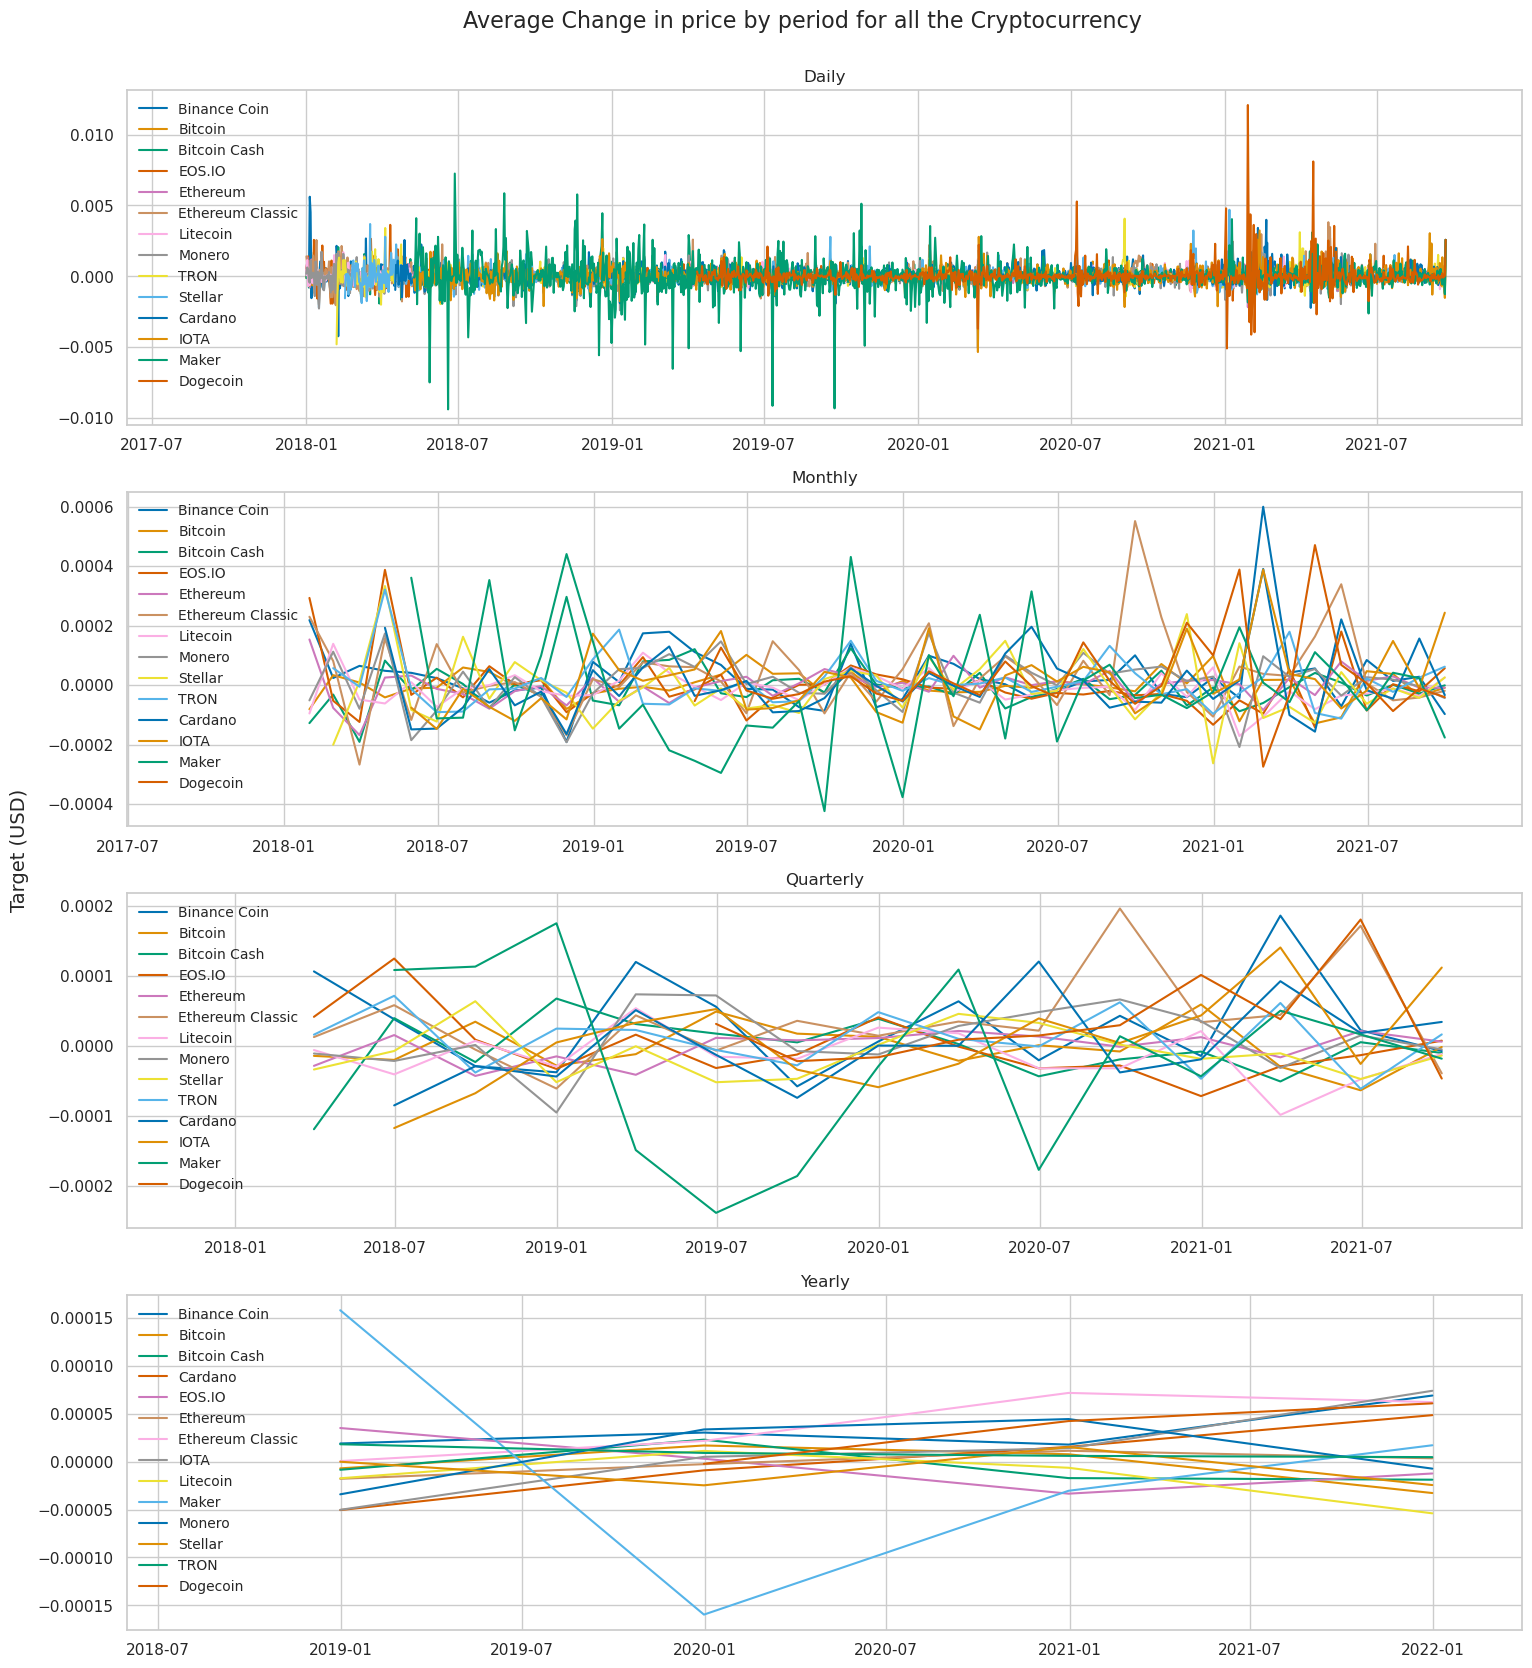

In [22]:
InteractiveShell.ast_node_interactivity = 'last_expr'
fig, axes = plt.subplots(4, 1, figsize=(18, 20))

periods = {'D': 'daily', 'M': 'monthly', 'Q': 'quarterly', 'Y': 'yearly'}

for i, (f, period) in enumerate(periods.items()):

    tmp = merged_crypto[['date', 'Target','Asset_Name']].groupby([pd.Grouper(key='date', freq=f), 'Asset_Name'])['Target'].mean().reset_index()
    sns.lineplot(data=tmp, x='date', y='Target', hue='Asset_Name', ax=axes[i] , palette = blind_colors)
    axes[i].set_xlim(tmp['date'].min() - pd.DateOffset(months=7), tmp['date'].max()+ pd.DateOffset(months=3))
    axes[i].set_title(period.title())
    axes[i].legend( loc='upper left',fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
fig.suptitle('Average Change in price by period for all the Cryptocurrency', fontsize=16, y=0.92)
fig.text(0.06, 0.5, 'Target (USD)', va='center', rotation='vertical', fontsize=14)
fig.show()

**Number of sample for each asset per year?**

In [32]:
pd.crosstab(index=merged_crypto.set_index('date').index.year, columns=merged_crypto.Asset_Name)

Asset_Name  Binance Coin  Bitcoin  Bitcoin Cash  Cardano  Dogecoin  EOS.IO   
row_0                                                                        
2018              516254   525588        524824   372254         0  524538  \
2019              521768   524969        522998   514334    326093  524870   
2020              526023   527014        527008   526570    452065  527022   
2021              378574   378711        378707   378709    378708  378710   

Asset_Name  Ethereum  Ethereum Classic    IOTA  Litecoin   Maker  Monero   
row_0                                                                      
2018          525588            523450  336463    525587    3043  359861  \
2019          524894            523106  446855    524720   10440  462965   
2020          527010            525865  430397    527014  278773  499790   
2021          378708            378706  378356    378709  378241  378645   

Asset_Name  Stellar    TRON  
row_0                        
2018         350276  444248  
2019         523198  524724  
2020         526565  526887  
2021         378710  378701

<a ><font size="2.5"><b>OBSERVATION:</b></font></a>
assets generally have a relatively consistent number of records across the four years of the dataset, with some minor fluctuations. But Dogecoin had no records in 2018

### **3. Feature Engineering**
- `UPS = High-max(Close, Open)` - Upper shadow; i.e. how high did the price get in the minute bar relative to where it started and closed. High values of this feature could indicate short-term reversions, low values could indicate short-term momentum/trend.
- `LOS = min(Close, Open)-Low)` - Lower shadow; i.e. how low did the price get in the minute bar relative to where it started and closed. High values of this feature could indicate short-term reversions, low values could indicate short-term momentum/trend.
- `RNG = (High-Low)/VWAP` - High-low range; i.e. how did the price fluctuate in the minute bar. This feature could be perceived as a volatility indicator. High (resp. low) values could indicate that the target might be high (resp. low) in absolute value.
- `MOV = (Close-Open)/VWAP` - Price move in the minute bar. This feature could be perceived as a momentum/trend indicator.  High (resp. low) values could indicate that the target might be high (resp. low).
- `LOGRETCO = log(Close/Open)` - Log-return Open-to-Close. This feature could be perceived as a momentum/trend indicator.  High (resp. low) values could indicate that the target might be high (resp. low).
- `RANKLOGRETCO = LOGRETCO.groupby('timestamp').rank('dense')` - How the Open-to-Close log-return of the cryptocurrency the row pertains to, ranks relative to the Open-to-Close log-returns of other cryptocurrencies in the same minute bar.
- `CLS = (Close-VWAP)/VWAP` - The last trade price in the bar relative to the average trade price. This could be perceived as a momentum/trend indicator. High (resp. low) values could indicate that prices are trending up (resp. down).
- `LOGVOL = log(1+Volume)` - Logarithm of the trade volume. Same as Volume but more robust to outliers. High volume could be an indication that returns will persist in the near future. Low volume and high returns could indicate a future market correction.
- `LOGCNT = log(1+Count)` - Logarithm of the number of trades in the bar. Same as Count but more robust to outliers. High count could be an indication that returns will persist in the near future. Low count and high returns could indicate a future market correction.
- `VOL2CNT = Volume/(1+Count)` - Average trade size in the bar. Can reveal whether there is a big player trading a large block, which would move the price further.
Temporal Features

In [93]:
merged_crypto.head()

timestamp  Asset_ID    Count        Open        High         Low   
0  1514764860         2  40.0000  2,376.5800  2,399.5000  2,357.1400  \
1  1514764860         0   5.0000      8.5300      8.5300      8.5300   
2  1514764860         1 229.0000 13,835.1940 14,013.8000 13,666.1100   
3  1514764860         5  32.0000      7.6596      7.6596      7.6567   
4  1514764860         7   5.0000     25.9200     25.9200     25.8740   

        Close     Volume        VWAP  Target  Weight        Asset_Name   
0  2,374.5900    19.2330  2,373.1164 -0.0042  2.3979      Bitcoin Cash  \
1      8.5300    78.3800      8.5300 -0.0144  4.3041      Binance Coin   
2 13,850.1760    31.5501 13,827.0621 -0.0146  6.7799           Bitcoin   
3      7.6576 6,626.7134      7.6577 -0.0139  1.3863            EOS.IO   
4     25.8770   121.0873     25.8914 -0.0083  2.0794  Ethereum Classic   

                 date  
0 2018-01-01 00:01:00  
1 2018-01-01 00:01:00  
2 2018-01-01 00:01:00  
3 2018-01-01 00:01:00  
4 2018-01-01 00:01:00

In [23]:
# Calculate Upper Shadow
merged_crypto_copy = merged_crypto.copy()
merged_crypto_copy['UPS'] = np.maximum(merged_crypto_copy['High'] - np.maximum(merged_crypto_copy['Close'], merged_crypto_copy['Open']), 0)
# Calculate Lower Shadow
merged_crypto_copy['LOS'] = np.maximum(np.minimum(merged_crypto_copy['Close'], merged_crypto_copy['Open']) - merged_crypto_copy['Low'], 0)
# Calculate Range
merged_crypto_copy['RNG'] = (merged_crypto_copy['High'] - merged_crypto_copy['Low']) / merged_crypto_copy['VWAP']
# Calculate Move
merged_crypto_copy['MOV'] = (merged_crypto_copy['Close'] - merged_crypto_copy['Open']) / merged_crypto_copy['VWAP']
# Calculate Log-Return Open-to-Close
merged_crypto_copy['LOGRETCO'] = np.log(merged_crypto_copy['Close']/ merged_crypto_copy['Open'] )
# Rank Log-Return Open-to-Close by timestamp
merged_crypto_copy['RANKLOGRETCO'] = merged_crypto_copy.groupby('timestamp')['LOGRETCO'].rank('dense')
# Calculate CLS
merged_crypto_copy['CLS'] = (merged_crypto_copy['Close'] - merged_crypto_copy['VWAP']) / merged_crypto_copy['VWAP']
# Calculate Logarithm of Volume
merged_crypto_copy['LOGVOL'] = np.log(1 + merged_crypto_copy['Volume'])
# Calculate Logarithm of Count
merged_crypto_copy['LOGCNT'] = np.log(1 + merged_crypto_copy['Count'])
# Calculate Volume to Count Ratio
merged_crypto_copy['VOL2CNT'] = merged_crypto_copy['Volume'] / (1 + merged_crypto_copy['Count'])
merged_crypto_copy.head()

timestamp  Asset_ID    Count        Open        High         Low   
0  1514764860         2  40.0000  2,376.5800  2,399.5000  2,357.1400  \
1  1514764860         0   5.0000      8.5300      8.5300      8.5300   
2  1514764860         1 229.0000 13,835.1940 14,013.8000 13,666.1100   
3  1514764860         5  32.0000      7.6596      7.6596      7.6567   
4  1514764860         7   5.0000     25.9200     25.9200     25.8740   

        Close     Volume        VWAP  Target  Weight        Asset_Name   
0  2,374.5900    19.2330  2,373.1164 -0.0042  2.3979      Bitcoin Cash  \
1      8.5300    78.3800      8.5300 -0.0144  4.3041      Binance Coin   
2 13,850.1760    31.5501 13,827.0621 -0.0146  6.7799           Bitcoin   
3      7.6576 6,626.7134      7.6577 -0.0139  1.3863            EOS.IO   
4     25.8770   121.0873     25.8914 -0.0083  2.0794  Ethereum Classic   

                 date      UPS      LOS    RNG     MOV  LOGRETCO   
0 2018-01-01 00:01:00  22.9200  17.4500 0.0178 -0.0008   -0.0008  \
1 2018-01-01 00:01:00   0.0000   0.0000 0.0000  0.0000    0.0000   
2 2018-01-01 00:01:00 163.6240 169.0840 0.0251  0.0011    0.0011   
3 2018-01-01 00:01:00   0.0000   0.0009 0.0004 -0.0003   -0.0003   
4 2018-01-01 00:01:00   0.0000   0.0030 0.0018 -0.0017   -0.0017   

   RANKLOGRETCO     CLS  LOGVOL  LOGCNT  VOL2CNT  
0        2.0000  0.0006  3.0073  3.7136   0.4691  
1        5.0000  0.0000  4.3742  1.7918  13.0633  
2        7.0000  0.0017  3.4828  5.4381   0.1372  
3        4.0000 -0.0000  8.7990  3.4965 200.8095  
4        1.0000 -0.0006  4.8047  1.7918  20.1812

### **4. Split Dataset to 14 sets**
Split the dataset to 14 sets based on the cryptocurrancy type (assets).

In [24]:
merged_crypto.head()

timestamp  Asset_ID    Count        Open        High         Low   
0  1514764860         2  40.0000  2,376.5800  2,399.5000  2,357.1400  \
1  1514764860         0   5.0000      8.5300      8.5300      8.5300   
2  1514764860         1 229.0000 13,835.1940 14,013.8000 13,666.1100   
3  1514764860         5  32.0000      7.6596      7.6596      7.6567   
4  1514764860         7   5.0000     25.9200     25.9200     25.8740   

        Close     Volume        VWAP  Target  Weight        Asset_Name   
0  2,374.5900    19.2330  2,373.1164 -0.0042  2.3979      Bitcoin Cash  \
1      8.5300    78.3800      8.5300 -0.0144  4.3041      Binance Coin   
2 13,850.1760    31.5501 13,827.0621 -0.0146  6.7799           Bitcoin   
3      7.6576 6,626.7134      7.6577 -0.0139  1.3863            EOS.IO   
4     25.8770   121.0873     25.8914 -0.0083  2.0794  Ethereum Classic   

                 date  
0 2018-01-01 00:01:00  
1 2018-01-01 00:01:00  
2 2018-01-01 00:01:00  
3 2018-01-01 00:01:00  
4 2018-01-01 00:01:00

In [64]:
groups = merged_crypto.groupby("Asset_Name")
for name, group in groups:

    df = pd.DataFrame(group).reset_index()
    df=df[['date', 'Count','Open','High','Low','Close','Volume','VWAP','Target', 'timestamp']]
    print(f"{name} Shape: {df.shape}")
    df.to_csv(f'./Datasets/CustomData/{name}.csv')

Binance Coin Shape: (1942619, 10)
Bitcoin Shape: (1956282, 10)
Bitcoin Cash Shape: (1953537, 10)
Cardano Shape: (1791867, 10)
Dogecoin Shape: (1156866, 10)
EOS.IO Shape: (1955140, 10)
Ethereum Shape: (1956200, 10)
Ethereum Classic Shape: (1951127, 10)
IOTA Shape: (1592071, 10)
Litecoin Shape: (1956030, 10)
Maker Shape: (670497, 10)
Monero Shape: (1701261, 10)
Stellar Shape: (1778749, 10)
TRON Shape: (1874560, 10)


**Save only sample from the datasets**

I will select the first 50000 samples from the each cryptoassets to be trained in the three selected models (Dlinear, FEDformer, and PatchTST) due to computational and time constraints.

In [70]:
groups = merged_crypto.groupby("Asset_Name")
for name, group in groups:

    df = pd.DataFrame(group).reset_index()
    df = df.iloc[:50000]
    df=df[['date', 'Count','Open','High','Low','Close','Volume','VWAP','Target', 'timestamp']]
    print(f"{name} Shape: {df.shape}")
    df.to_csv(f'./Datasets/CustomData/{name}.csv', index=False)

Binance Coin Shape: (50000, 10)
Bitcoin Shape: (50000, 10)
Bitcoin Cash Shape: (50000, 10)
Cardano Shape: (50000, 10)
Dogecoin Shape: (50000, 10)
EOS.IO Shape: (50000, 10)
Ethereum Shape: (50000, 10)
Ethereum Classic Shape: (50000, 10)
IOTA Shape: (50000, 10)
Litecoin Shape: (50000, 10)
Maker Shape: (50000, 10)
Monero Shape: (50000, 10)
Stellar Shape: (50000, 10)
TRON Shape: (50000, 10)


---
<h1 style="text-align:center;">Bitcoin Dataset</h1>

---

## Load Bitcoin dataset

In [25]:
InteractiveShell.ast_node_interactivity = "all"
used_data = 'Bitcoin'
Bitcoin_df = pd.read_csv(f"./Datasets/CustomData/{used_data}.csv",index_col = 0)
Bitcoin_df.index.freq = 't'
Bitcoin_df.shape
Bitcoin_df.head()

date    Count        Open        High         Low   
0  2018-01-01 00:01:00 229.0000 13,835.1940 14,013.8000 13,666.1100  \
1  2018-01-01 00:02:00 235.0000 13,835.0360 14,052.3000 13,680.0000   
2  2018-01-01 00:03:00 528.0000 13,823.9000 14,000.4000 13,601.0000   
3  2018-01-01 00:04:00 435.0000 13,802.5120 13,999.0000 13,576.2800   
4  2018-01-01 00:05:00 742.0000 13,766.0000 13,955.9000 13,554.4400   

        Close   Volume        VWAP  Target  
0 13,850.1760  31.5501 13,827.0621 -0.0146  
1 13,828.1020  31.0464 13,840.3626 -0.0150  
2 13,801.3140  55.0618 13,806.0680 -0.0103  
3 13,768.0400  38.7805 13,783.5981 -0.0090  
4 13,724.9140 108.5016 13,735.5868 -0.0081

---
## Bitcoin - Preprocessing and EDA

---

### **1. Check Data Quality**

In [26]:
numeric_cols = Bitcoin_df.select_dtypes(include=['float64']).columns.tolist()
print(np.isnan(Bitcoin_df[numeric_cols].values).any())
print(np.isinf(Bitcoin_df[numeric_cols].values).any())

False
False


In [ ]:
Bitcoin_df.set_index('timestamp', inplace=True)

In [ ]:
(Bitcoin_df.index[1:]-Bitcoin_df.index[:-1]).value_counts().head()

<a ><font size="2.5"><b>OBSERVATION:</b></font></a>
There are roughly 120 gaps. It is important to reformat the data to remove these gaps so we only have 60-second gaps

In [ ]:
Bitcoin_df = Bitcoin_df.reindex(range(Bitcoin_df.index[0], Bitcoin_df.index[-1] + 60, 60), method='pad')

In [ ]:
(Bitcoin_df.index[1:] - Bitcoin_df.index[:-1]).value_counts().head()

In [ ]:
Bitcoin_df = Bitcoin_df.reset_index()
Bitcoin_df['date'] = pd.to_datetime(Bitcoin_df['timestamp'], unit='s')
Bitcoin_df = Bitcoin_df[['date','Count','Open','High','Low','Close','Volume','VWAP','Target']]

In [ ]:
Bitcoin_df.head()

In [ ]:
# Overwrite the dataset 
Bitcoin_df.to_csv(f'./Datasets/CustomData/Bitcoin.csv')

### **2. Decomposition**
Breaking down a time series into three systematic components: trend-cycle, seasonal variation, and random fluctuations. 
- The trend component represents the long-term direction of the time series, which can be increasing, decreasing, or stable over time. 
- The seasonal component represents the recurring patterns that occur within the time series, such as yearly or quarterly cycles. 
- The random fluctuations component represents the random noise in the data that cannot be explained by the trend or seasonal components.

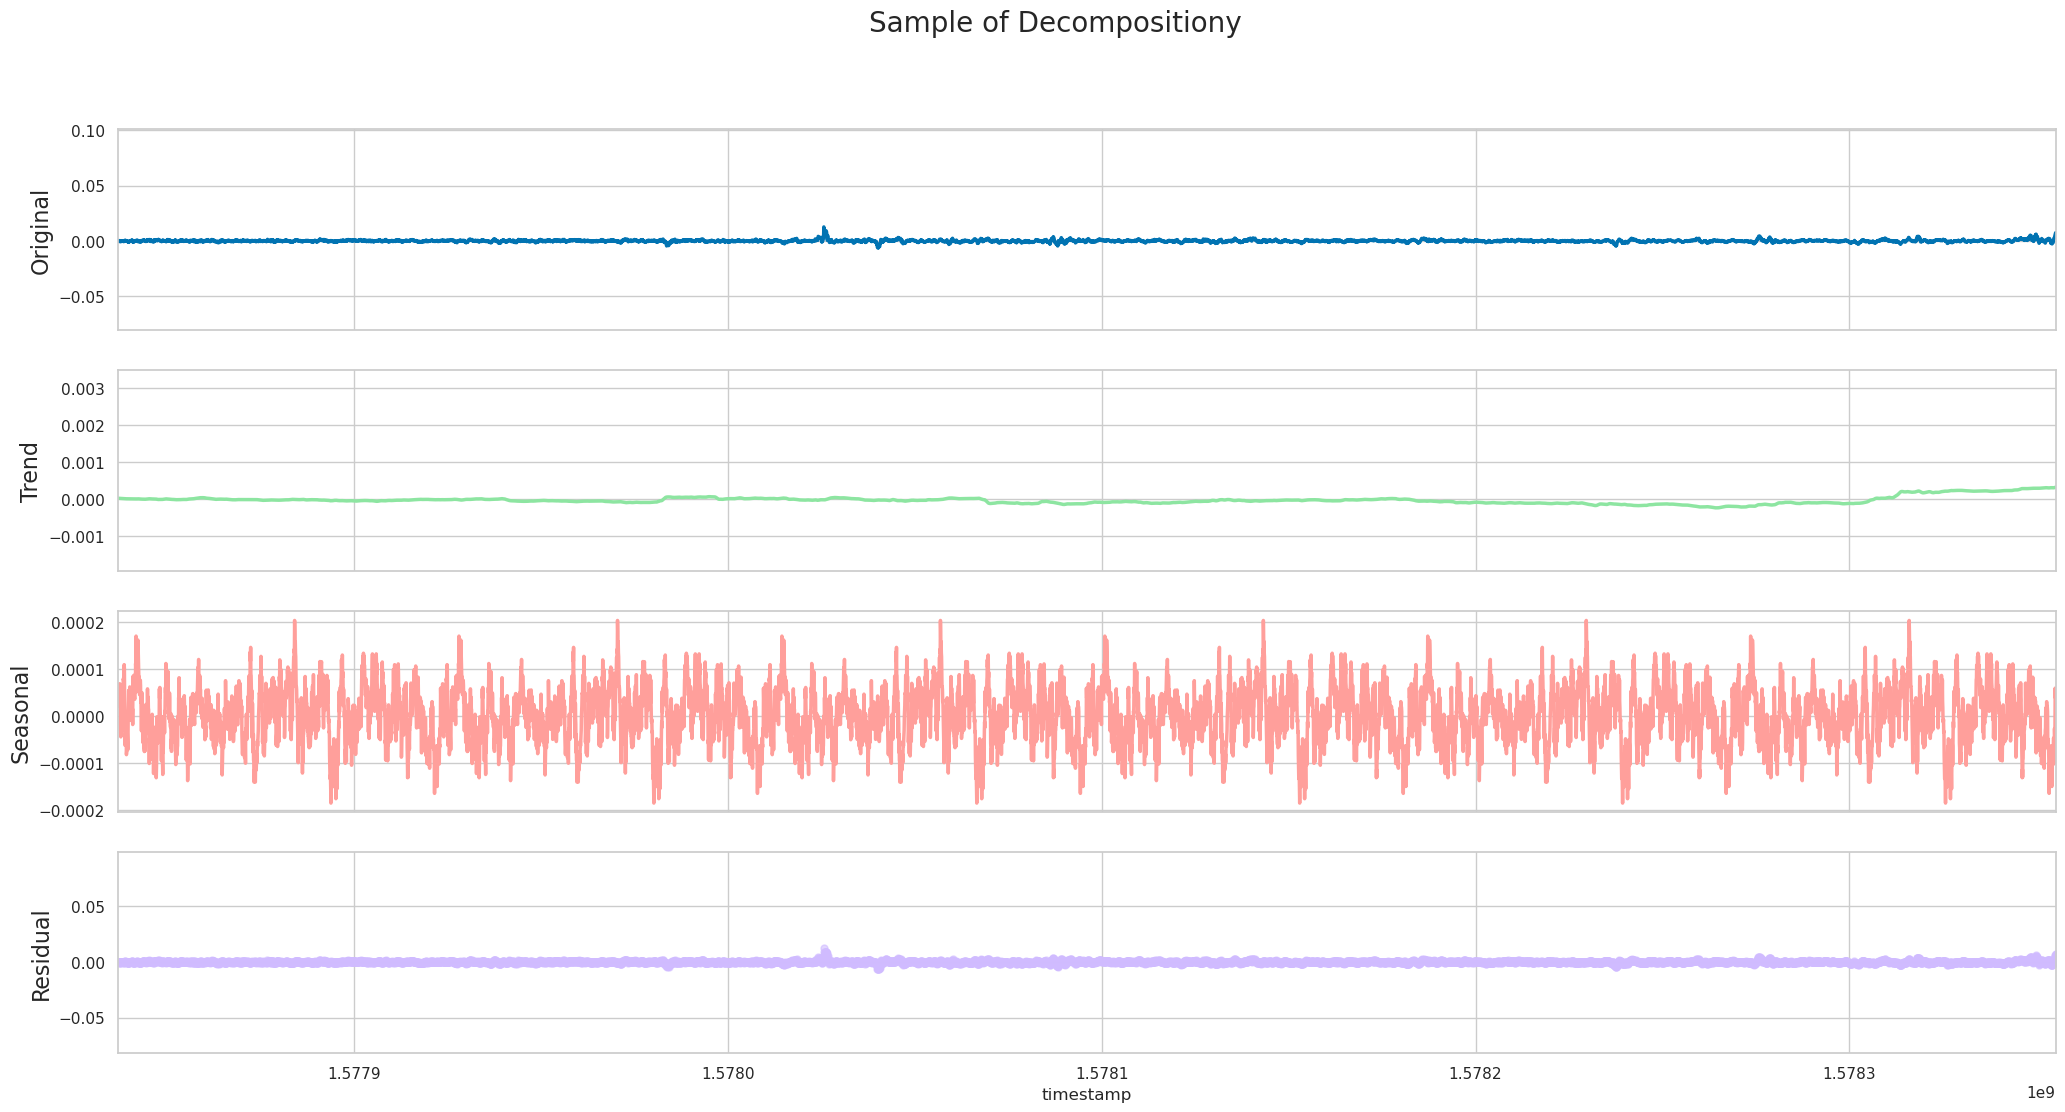

In [33]:
InteractiveShell.ast_node_interactivity = 'last_expr'
fig, axes = plt.subplots(4, 1, figsize=(25, 12), sharex= True);

decomposition = seasonal_decompose(Bitcoin_df[['Target']], model='additive', period=60*24) # period = Daily

Bitcoin_df[['Target']].plot(lw = 2.5, ax=axes[0], legend=False);
decomposition.trend.plot(lw = 2.5,ax=axes[1], color=pastel_colors[2] , legend=False);
decomposition.seasonal.plot(lw = 2.5, ax=axes[2], color=pastel_colors[3], legend=False);
decomposition.resid.plot(lw=0, marker='o', alpha = 0.6, markersize=5, ax=axes[3],color=pastel_colors[4], legend=False);

axes[0].set_ylabel('Original', fontsize=16);
axes[1].set_ylabel('Trend', fontsize=16);
axes[2].set_ylabel('Seasonal', fontsize=16);
axes[3].set_ylabel('Residual', fontsize=16);

start_date = int(pd.to_datetime('2020-01-01').timestamp())
end_date = int(pd.to_datetime('2020-01-7').timestamp())
axes[0].set_xlim([start_date, end_date])
axes[1].set_xlim([start_date, end_date])
axes[2].set_xlim([start_date, end_date])
axes[3].set_xlim([start_date, end_date])

fig.suptitle('Sample of Decompositiony', fontsize=20);
plt.show()

<a ><font size="2.5"><b>OBSERVATION:</b></font></a>
- Data is seasonal.
- Trend is a fluctuated curve.
- As seasonal is a repeating pattern over fixed periods, this cause the trend to fluctuate up and down as the seasonal effects interact with the overall trend.
- A recognizable pattern in the residuals, but we will check the autocorrelations using Ljung-Box test.
- We want the residuals to be i.i.d (uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. 

**Ljung-Box Staticl test for :** The Ljung-Box test is a statistical test used to determine whether a set of autocorrelations of a time series are different from zero based on the Q statistic. The Q statistic is a measure of the sum of squared autocorrelations of the residuals up to a certain lag.

In [32]:
resid = decomposition.resid.dropna()
ljung = sm.stats.acorr_ljungbox(resid, return_df=True)
ljung_p_val = np.mean(ljung.iloc[:,1]).round(3)
print("P value=", ljung_p_val, ", Residuals are uncorrelated" if ljung_p_val > 0.05 else ", Residuals are correlated")

P value= 0.01 , Residuals are correlated


<a ><font size="2.5"><b>OBSERVATION:</b></font></a>
Based on this p-value, we have strong evidence of significant serial correlation in the residuals. We can perform transformations to see if it stabilizes the variance. 

In [ ]:
sns.set_theme(style="whitegrid", palette=blind_colors[9:])
sm.qqplot(resid, line='s');

**Stabilizes the variance:** We will use Box-Cox to adjust the skewness and kurtosis of the data by raising the data to a power that depends on a parameter known as lambda (λ).

In [36]:
# take data sample for vusialization
InteractiveShell.ast_node_interactivity = 'last_expr'
sample = Bitcoin_df.Target[:500]

### **3. Plot moving averages window**
Calculating the average of a certain number (5, 10, 15, 30, 60) of previous data points, called the window, and using that average as a smoothed estimate of the current value.

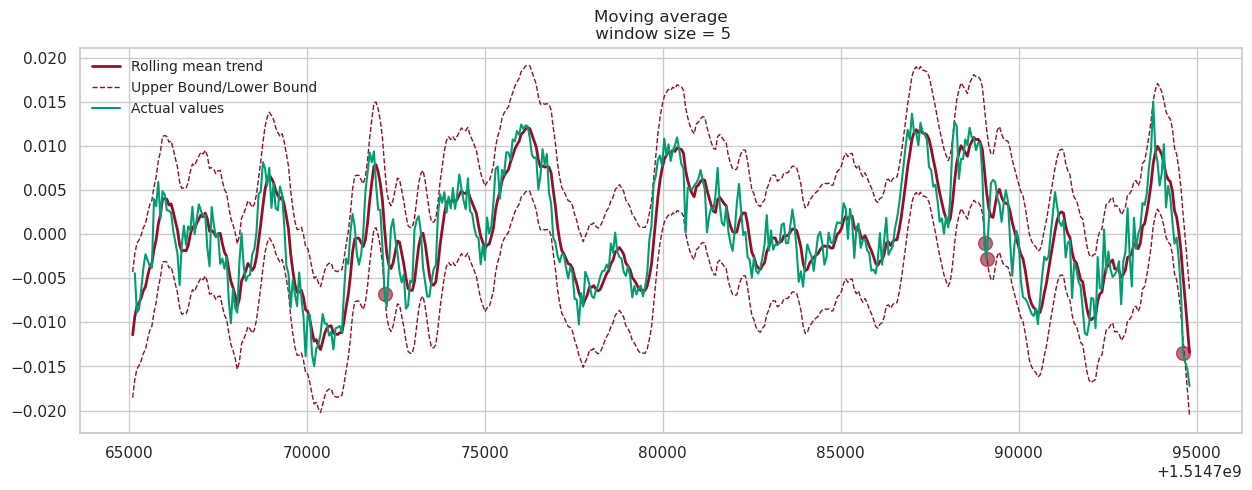

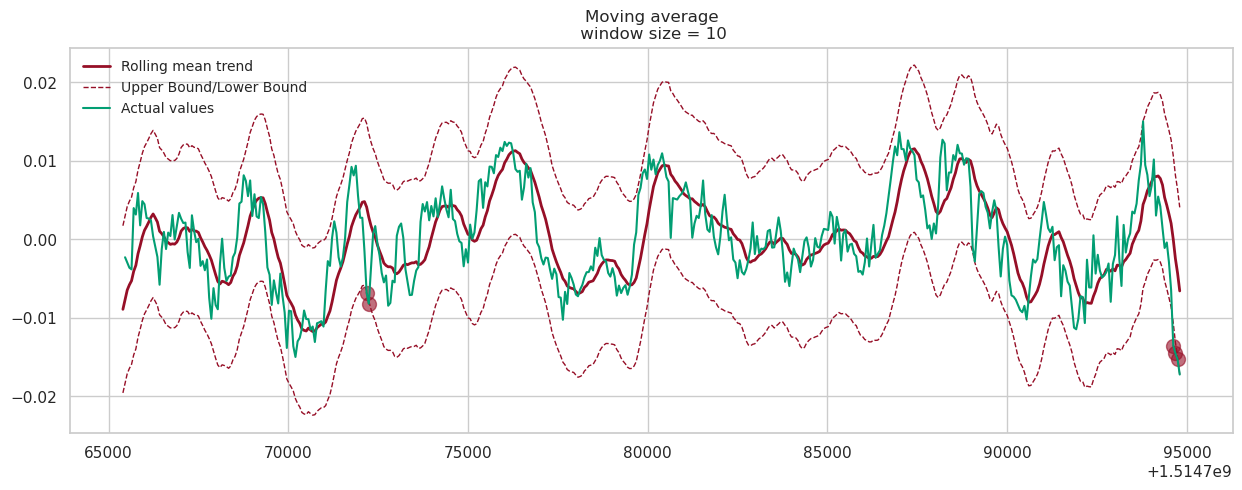

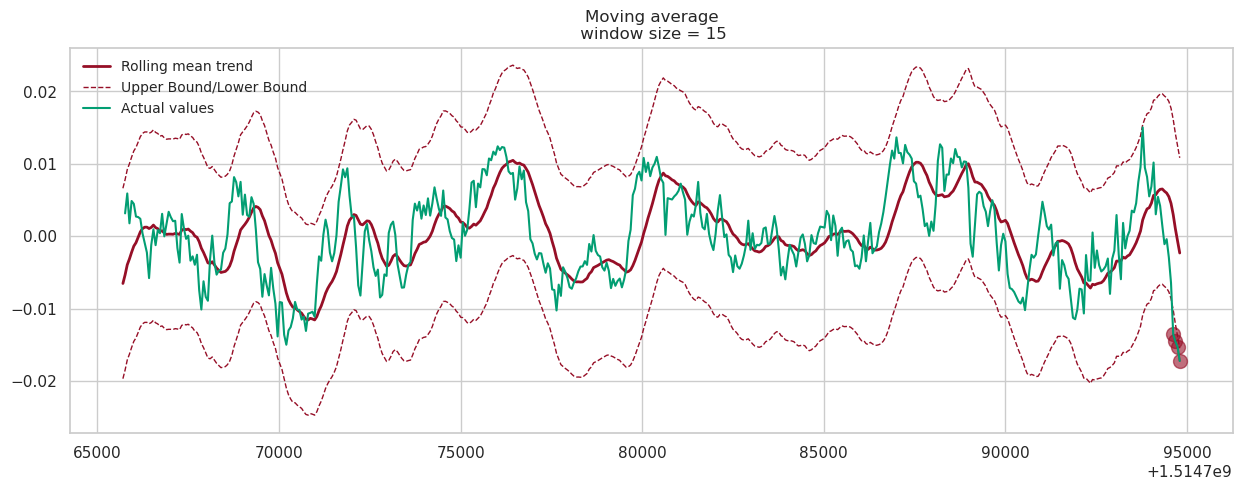

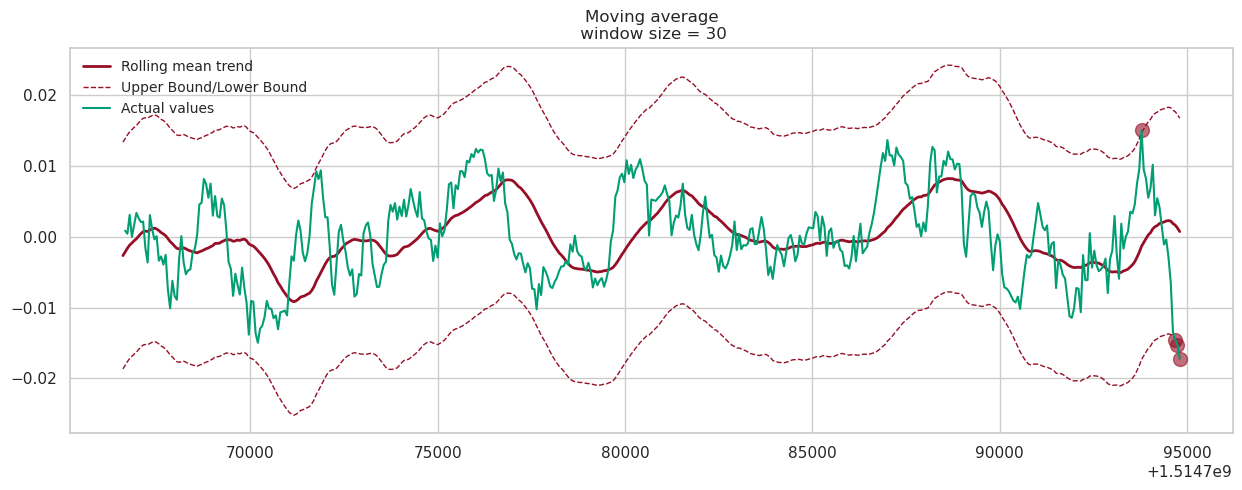

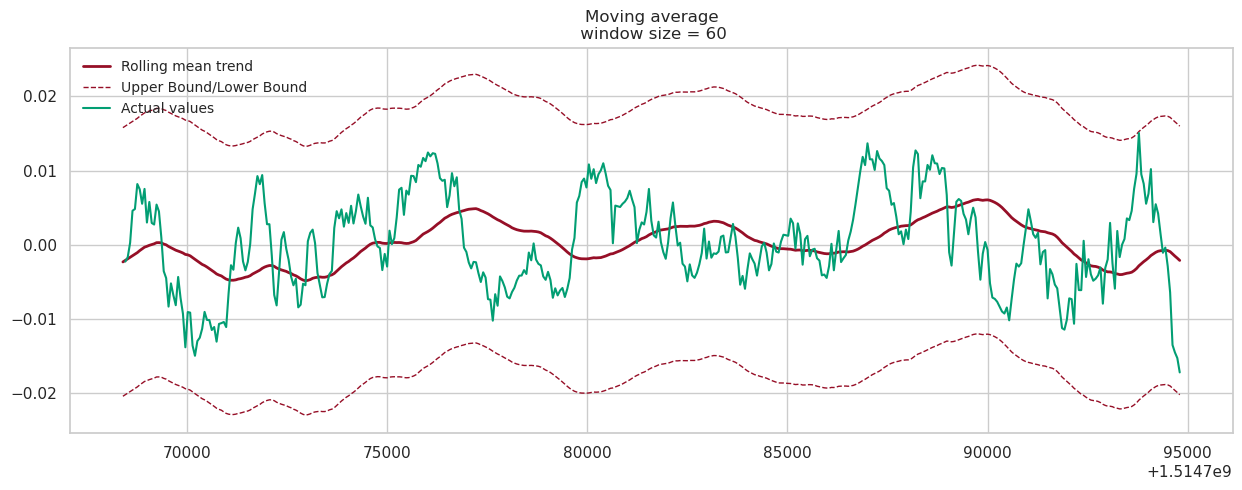

In [44]:
# Let's take a look at several moving averages
windows = [5, 10, 15, 30, 60]
for window in windows:
    MovingAveragePlot(sample, window=window,plot_intervals=True, plot_anomalies=True)

**I will try to predict anomlies by another method**

### **4. Exponential Smoothing**
Exponential smoothing is producing stable and accurate forecasts from time series data. It is particularly useful when the data is noisy or contains irregular fluctuations. It works by assigning exponentially decreasing weights to past observations, with more recent observations receiving higher weights than older ones.
$$F(t+1) = alpha * D(t) + (1 - alpha) * F(t)$$
- The value of alpha typically ranges between 0 and 1.
- Higher alpha values indicating more weight given to recent observations.

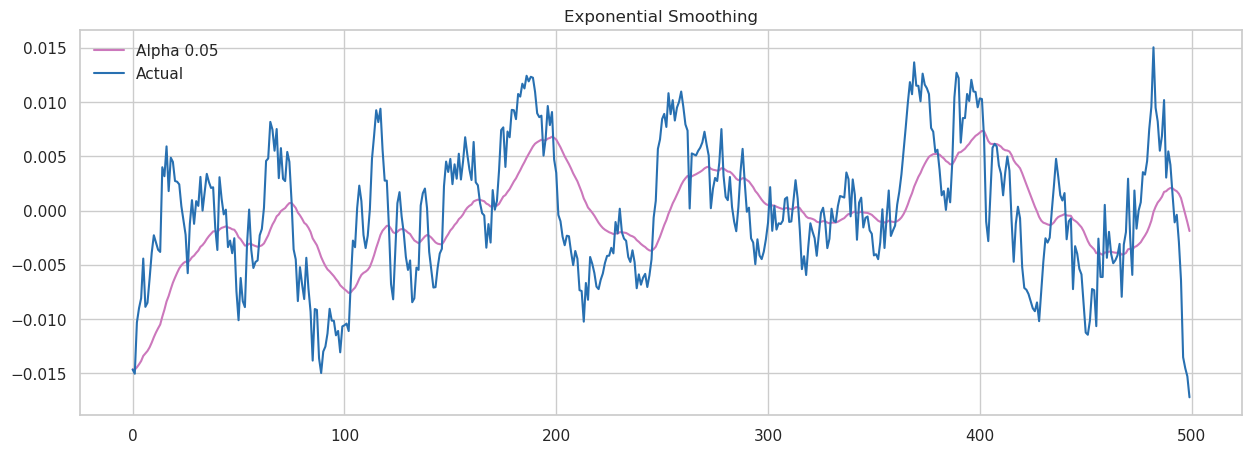

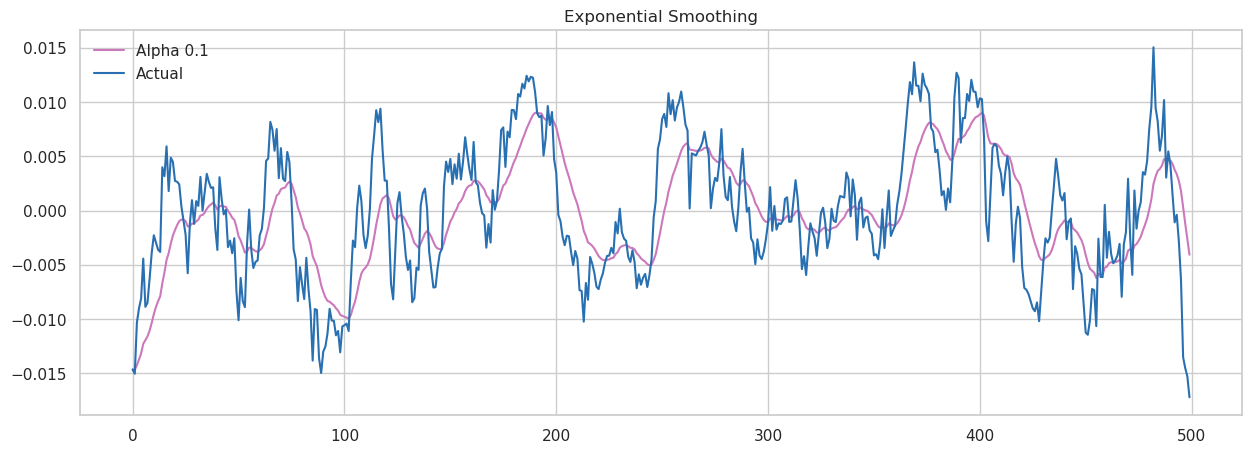

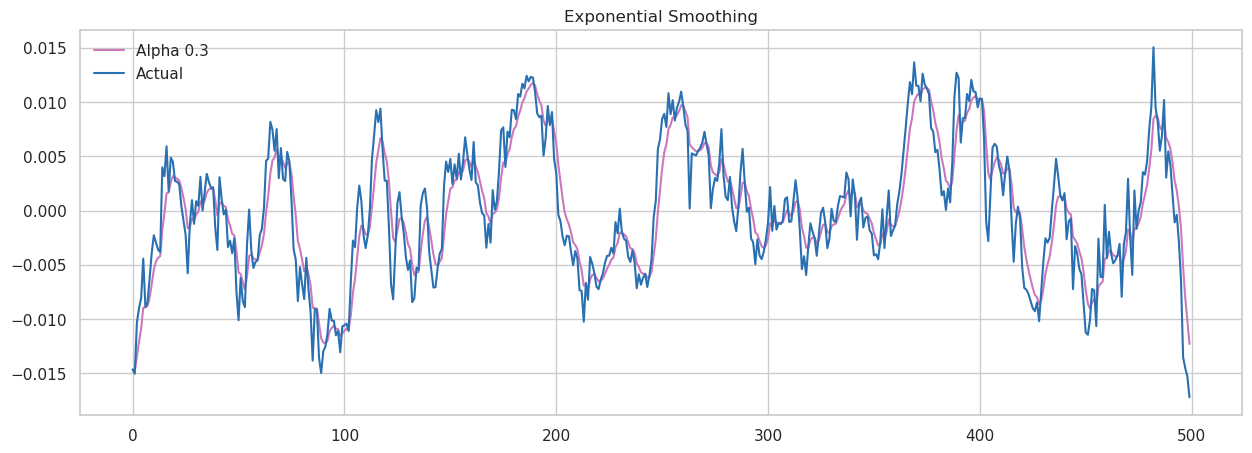

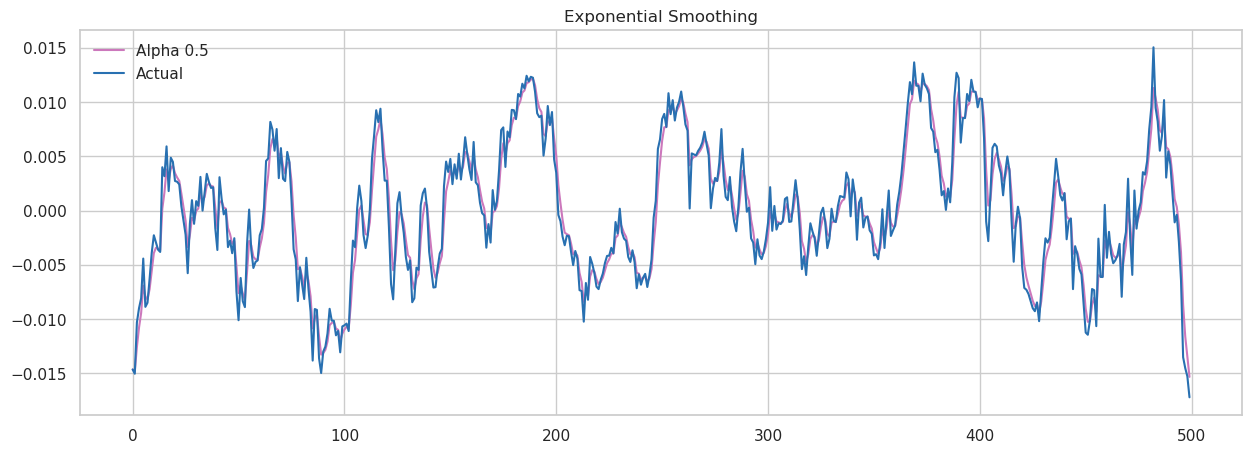

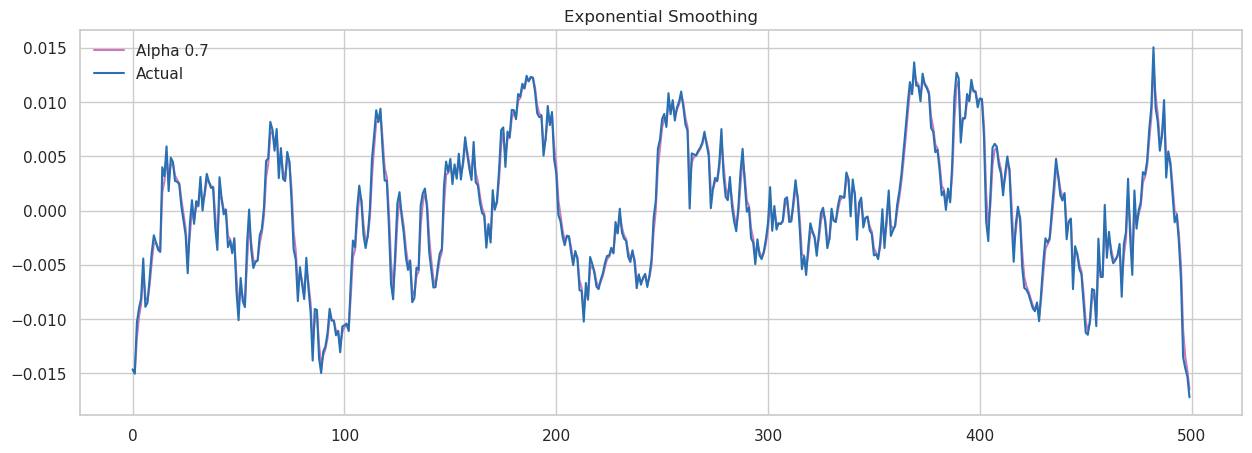

In [45]:
alphas = [.05, .1, .3, .5, .7]
for alpha in alphas:
    ExponentialSmoothingPlot(sample, alphas=[alpha])

<a ><font size="2.5"><b>OBSERVATION:</b></font></a>
When comparing smaller and larger alphas, it becomes evident that smaller alphas tend to cause the data to undergo a transformation that results in a flattened series, thereby enhancing the predictability of the data is not accurate and could be misleading.

### **5. Check Stationarity**
Stationarity is crucial for time-series forecasting. It implies the statistical properties of the data have NO correlation with time. A stationary process is much more predictable than a non-stationary process. For the series to be stationary, it must have:
- Constant mean
- Constant variance
- Constant covariance (uncorrelated)
- No Seasonality.

We verify this by observing change in mean, variance, autocorrelation and with a statistical test (Auller test)

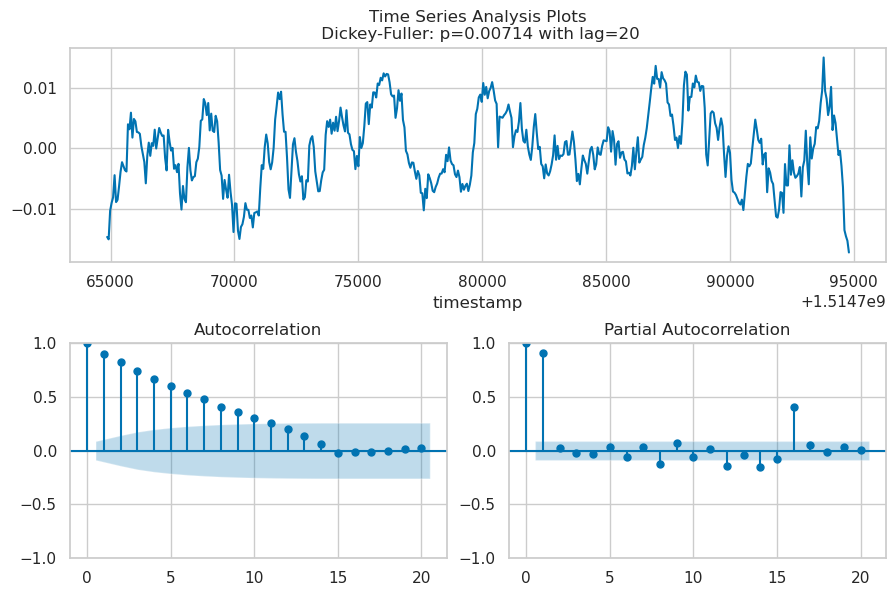

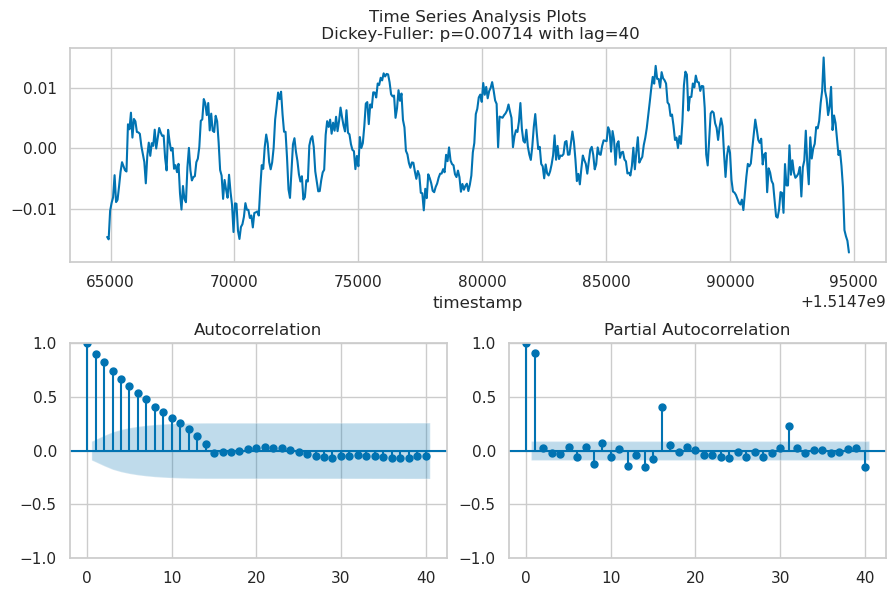

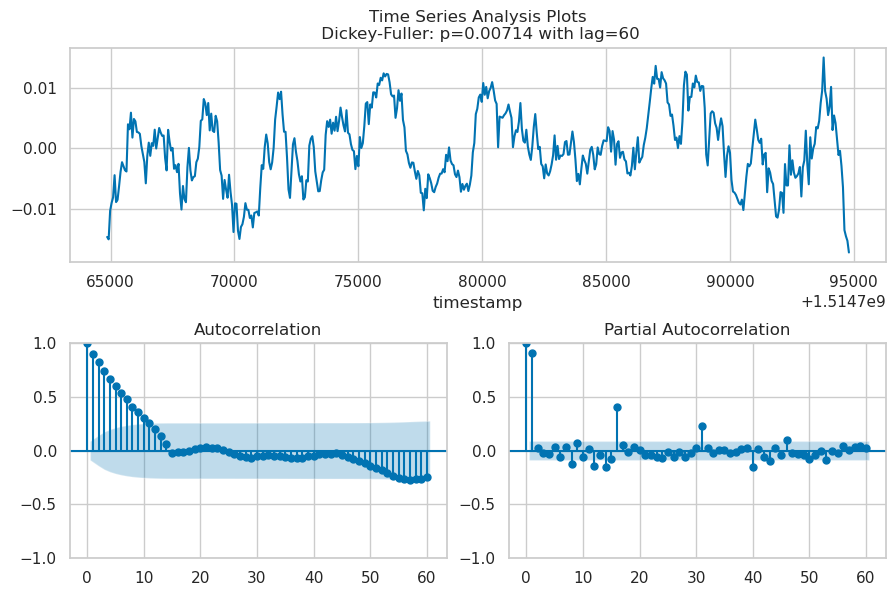

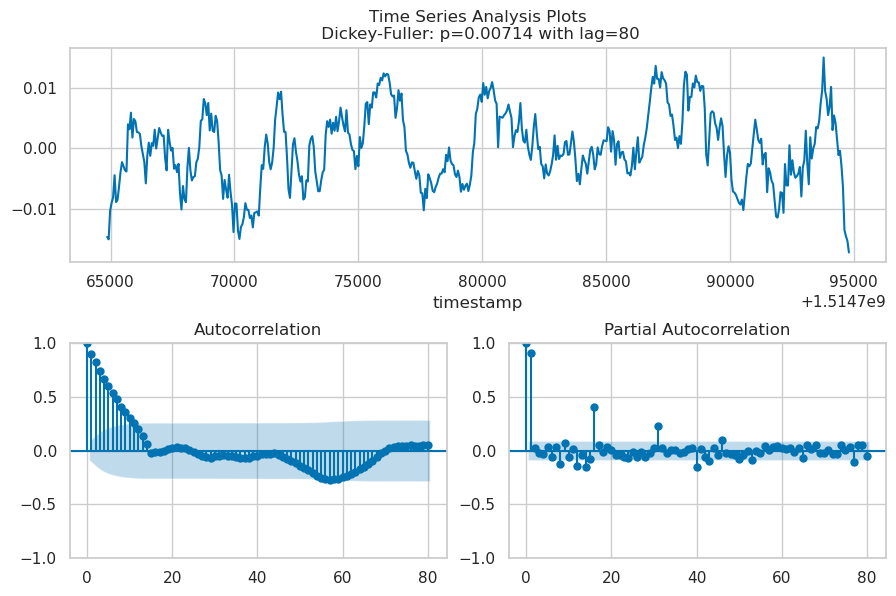

In [46]:
lags = [20,40,60,80]
for lag in lags:
    StationartyPlot(sample, lags=lag)

**Smoothing series with exponential smoothing and retry Dickey-Fuller Test**

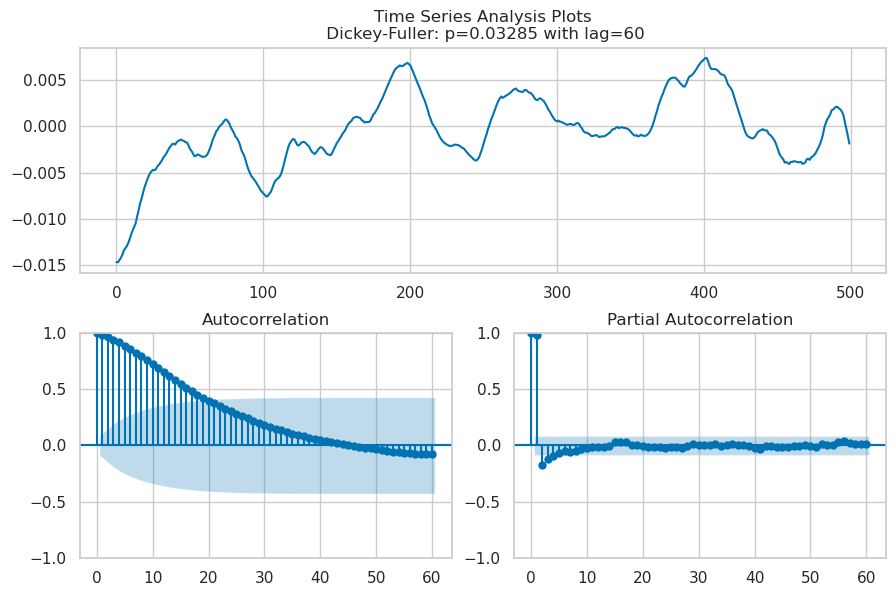

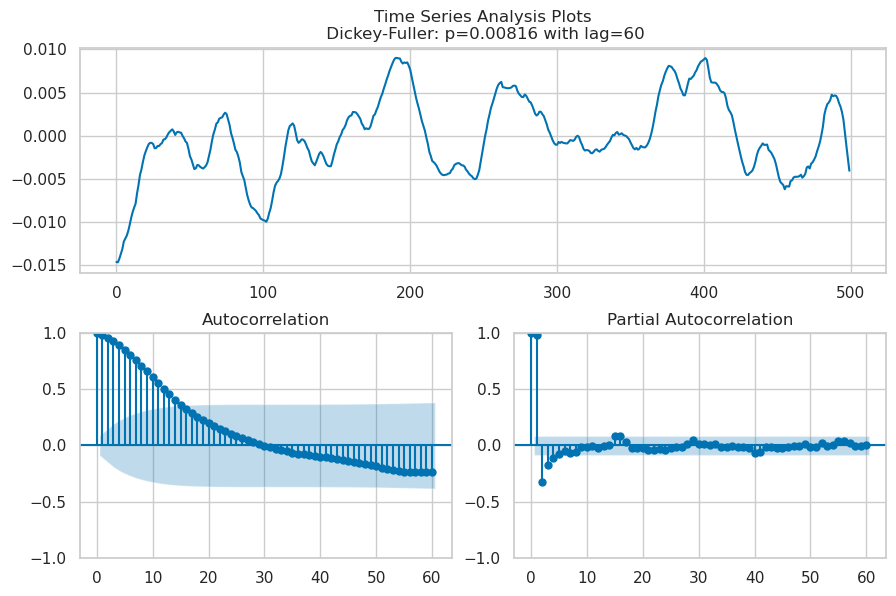

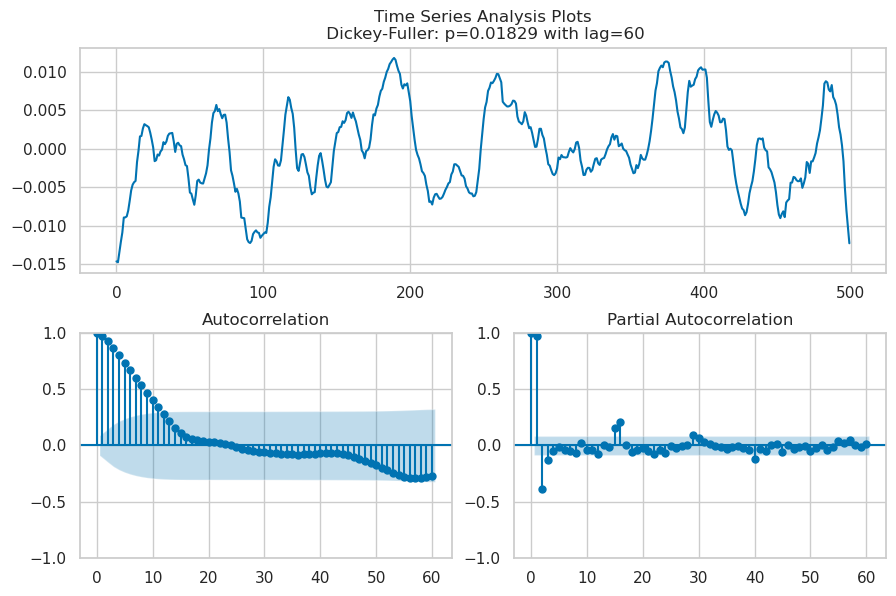

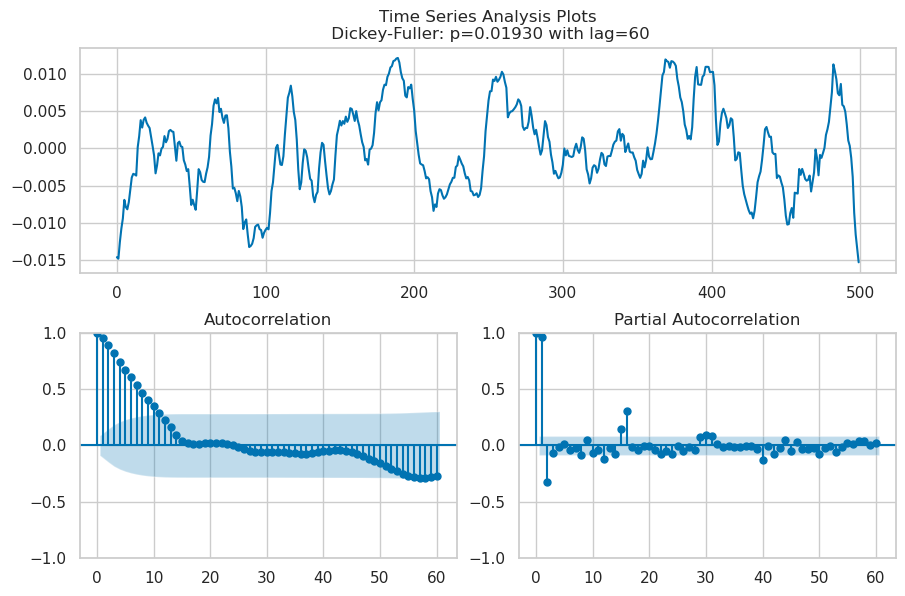

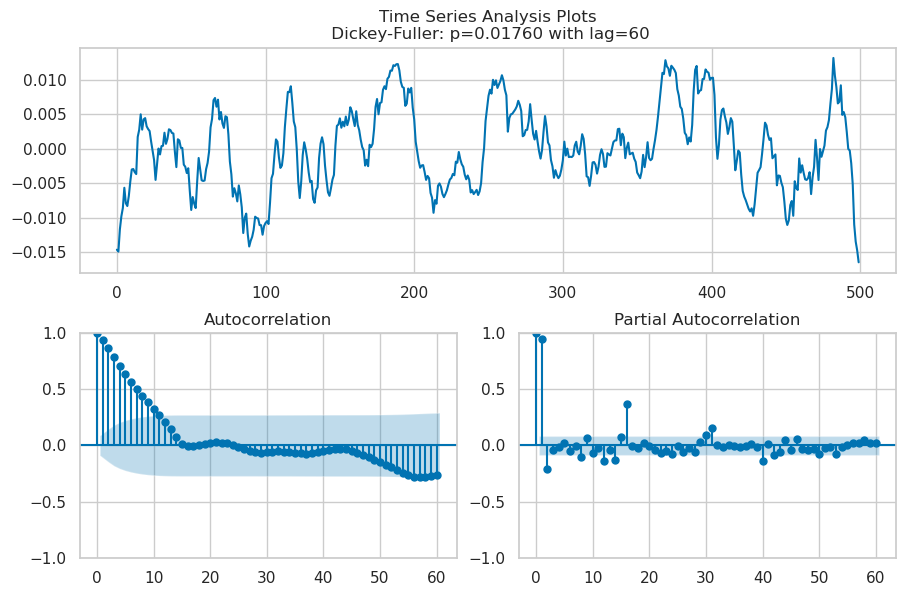

In [47]:
alphas = [.05, .1, .3, .5, .7]
for alpha in alphas:
    current_series = exponential_smoothing(sample, alpha)
    StationartyPlot(current_series, lags=60)

**Taking a first-order difference and retry Dickey-Fuller Test**

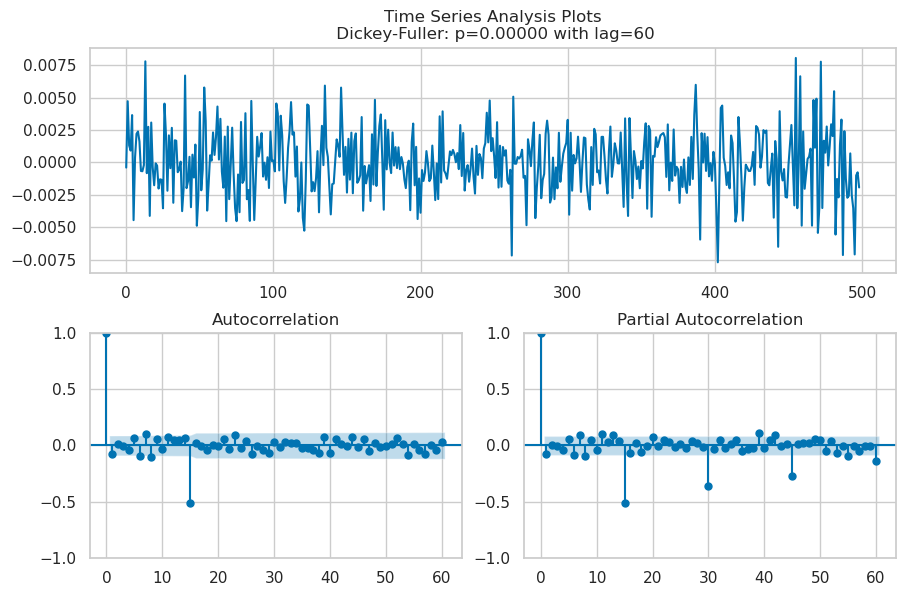

In [37]:
sample_frist_diff = sample - sample.shift(1)
StationartyPlot(sample_frist_diff[1:].values, lags=60)

---
## Bitcoin - Modeling Using ARIMA

---

Choosing ARIMA as a basline model from the traditional models.

In [ ]:
def ARIMA_Model(datafiles, n_steps_to_predict, n_steps_to_plot):
    
    p = 2
    d = 0
    q = 13
    alpha = 0.05
    models = dict()
    errors = dict()
    forecasts = dict()

    for i, asset_name in enumerate(datafiles):
    
        print("="*100)
        print(f"{asset_name:<110}".center(200))
        print("="*100)
        print(f"> Loading {asset_name} dataset")
        start_time = time.time()
        current_dataset = pd.read_csv(f'./Datasets/CustomData/{asset_name}.csv', index_col= 'timestamp',parse_dates=True)
        training_dataset = current_dataset.iloc[:-n_steps_to_predict,:]
        print(f"\n   Training Data Period = {len(training_dataset)} mins,     Testing Data Period = {n_steps_to_predict} mins,     Loading Time = {time.time()-start_time:0.2f} secs\n")

    ############################################################################################################################################################
        # Calculate exponential smoothing
        print(f"> Smoothing with alpha: {alpha}")
        training_dataset["Smoothed"] = exponential_smoothing(training_dataset.Target, alpha=alpha)
        data = training_dataset["Target"]
    ############################################################################################################################################################
        # Training
        print(f"> Training ", end='')
        start_time=time.time()
        model = statsmodels.tsa.arima.model.ARIMA(endog=data.values, exog=None, order=(p,d,q)).fit() 
        print(f"\n   Training Results:     AIC = {model.aic:0.2f},     Training Time = {(time.time()-start_time)/60.0:0.2f} mins\n")
    ############################################################################################################################################################
        # Forecasting
        print(f"> Evaluating ",end='')

        start_time = time.time()
        actual = np.array(data.values)
        arima_model = np.array(model.fittedvalues)

        forecast = list(model.predict(start = len(actual), end = len(actual)+n_steps_to_predict))
        forecast = list(arima_model) + forecast

        forecasts[asset_name] = forecast
        models[asset_name] = model
        errors[asset_name]= [rmse(actual, arima_model), mean_absolute_error(actual, arima_model), mean_absolute_percentage_error(actual, arima_model)]
        print(f"\n   Forecasting Results:   RMSE= {errors[asset_name][0]:.2f},     MAE= {errors[asset_name][1]:.2f},     %MAPE= {errors[asset_name][2]:.2f}%     Testing Time = {time.time()-start_time:0.2f} mins\n")
    ############################################################################################################################################################
        # Plot results 
        plt.figure(figsize=(15, 4))
        plt.axvspan(len(forecast[-n_steps_to_plot:])-n_steps_to_predict, len(forecast[-n_steps_to_plot:]), alpha=0.5, color='lightgrey')
        plt.plot(actual[-n_steps_to_plot:], label="Actual")
        plt.plot(forecast[-n_steps_to_plot:], color = RdBu_colors[0], label="Model")
        plt.legend()
        plt.grid(True);
        plt.show()

### **1. Evaluting ARIMA by predicting 10 future values**

                                             Bitcoin                                                                                                                                                    
> Loading Bitcoin dataset

   Training Data Period = 49990 mins,     Testing Data Period = 10 mins,     Loading Time = 0.15 secs

> Smoothing
> Training 
   Training Results:     AIC = -508022.30,     Training Time = 1.80 mins

> Evaluating 
   Forecasting Results:   RMSE= 0.00,     MAE= 0.00,     %MAPE= 4.40%     Testing Time = 0.01 mins



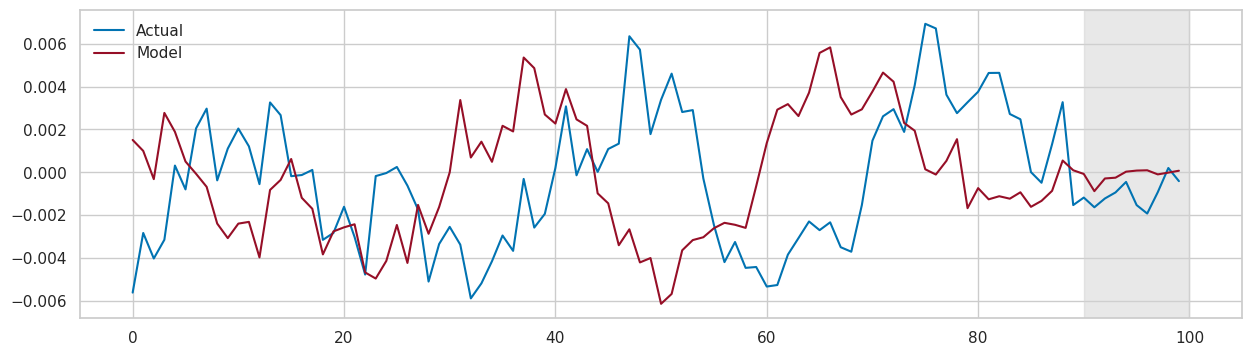

CPU times: user 4min 41s, sys: 19min 12s, total: 23min 54s
Wall time: 1min 48s


In [44]:
%%time

datafiles = ['Bitcoin'] 
n_steps_to_predict = 10 
n_steps_to_plot = 100

ARIMA_Model(n_steps_to_predict, n_steps_to_plot)

### **2. Evaluting ARIMA by predicting 100 future values**

                                             Bitcoin                                                                                                                                                    
> Loading Bitcoin dataset

   Training Data Period = 49900 mins,     Testing Data Period = 100 mins,     Loading Time = 0.11 secs

> Smoothing
> Training 
   Training Results:     AIC = -507141.72,     Training Time = 2.08 mins

> Evaluating 
   Forecasting Results:   RMSE= 0.00,     MAE= 0.00,     %MAPE= 4.40%     Testing Time = 0.01 mins



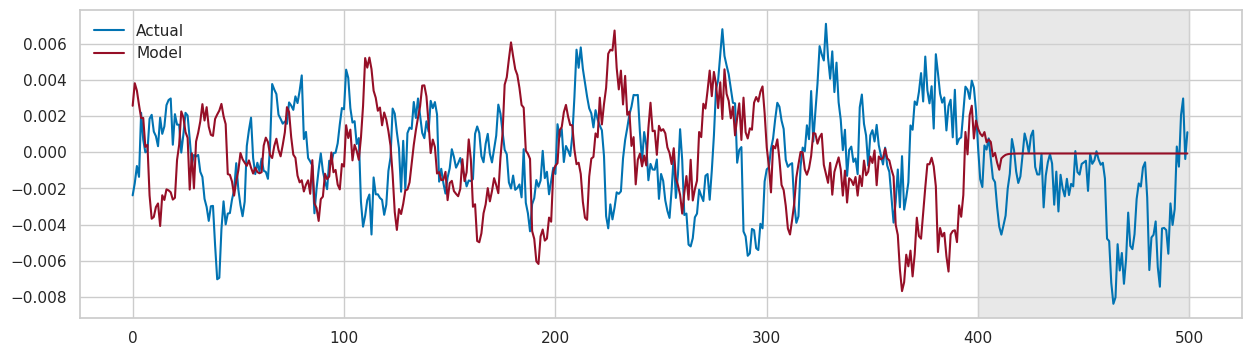

CPU times: user 5min 26s, sys: 22min 29s, total: 27min 56s
Wall time: 2min 4s


In [45]:
%%time

n_steps_to_predict = 100 
n_steps_to_plot = 500

ARIMA_Model(n_steps_to_predict, n_steps_to_plot)

---
## Bitcoin - Evaluating DLinear

---

In [34]:
def Evaluate( model_name, pred_len, ax, colors):
    """
    Plots the predicted and true values for a given model and prediction horizon (pred_len).

    Args:
    model_name (str): The name of the model used to make predictions.
    pred_len (int): The length of the prediction horizon (i.e., the number of future values to predict).
    ax (matplotlib.axes.Axes): A Matplotlib Axes object on which to draw the plot.
    colors (List[str]): A list of two colors to use for the actual and predicted lines, respectively.
    
    """
    
    InteractiveShell.ast_node_interactivity = 'last_expr'
    
    setting = model_name+'_train_on_Bitcoin_'+str(pred_len)
    trues = np.load('./results/'+ setting +'/true.npy') # [samples, pred_len, dimensions]
    preds = np.load('./results/'+ setting +'/pred.npy') # [samples, pred_len, dimensions]
    mae, mse, rmse, mape, mspe = np.load('./results/'+ setting +'/metrics.npy', allow_pickle=True) 
#     print("Prediction labels shape: {}, Actual labels ahape:{}".format(preds.shape, trues.shape))
    print(setting + '\t: mae:{:0.2f}, mse:{:0.2f}, rmse:{:0.2f}, mape:{:0.2f}, mspe:{:0.2f}'.format(mae, mse, rmse, mape, mspe))
    
    for i, data in enumerate([trues[0,:,-1], preds[0,:,-1]]):
        sns.lineplot(x=range(len(data)), y=data, label=["Actual", model_name][i], color=colors[i], ax=ax)
    ax.set_title(f"{model_name} results of {pred_len} future values of `Target` column".title())
    ax.legend()

DLinear_train_on_Bitcoin_96	: mae:0.46, mse:0.41, rmse:0.64, mape:1.56, mspe:198.70
DLinear_train_on_Bitcoin_192	: mae:0.47, mse:0.43, rmse:0.66, mape:1.73, mspe:267.97
DLinear_train_on_Bitcoin_336	: mae:0.47, mse:0.44, rmse:0.66, mape:1.71, mspe:248.70
DLinear_train_on_Bitcoin_720	: mae:0.48, mse:0.45, rmse:0.67, mape:1.76, mspe:280.39


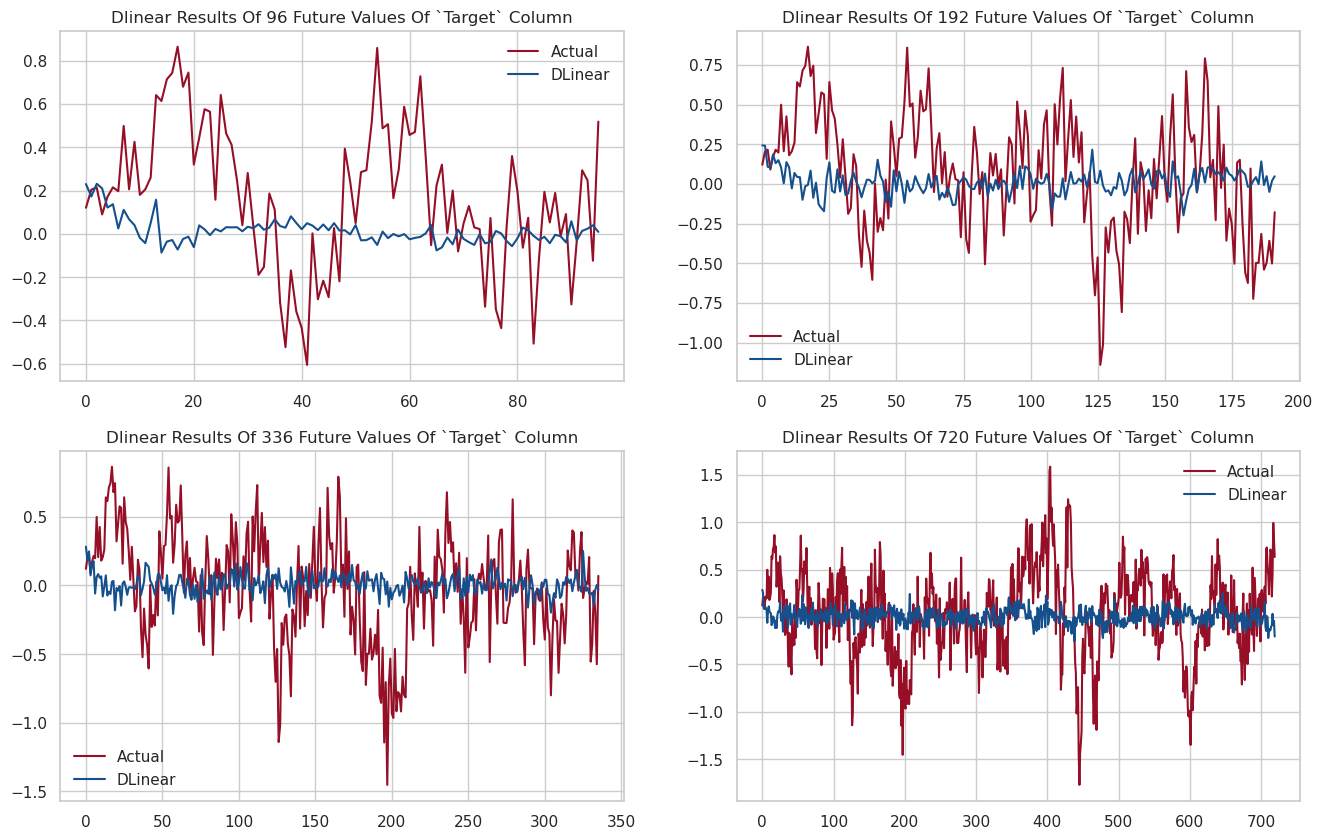

In [25]:
pred_lens = [96,192,336,720]
colors = [RdBu_colors[0], RdBu_colors[-1]]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate("DLinear", pred_len,ax, colors)

plt.show()

---
## Bitcoin - Evaluating NLinear

---

NLinear_train_on_Bitcoin_96	: mae:0.47, mse:0.43, rmse:0.66, mape:1.95, mspe:347.02
NLinear_train_on_Bitcoin_192	: mae:0.47, mse:0.44, rmse:0.66, mape:1.83, mspe:227.28
NLinear_train_on_Bitcoin_336	: mae:0.47, mse:0.44, rmse:0.67, mape:1.80, mspe:224.23
NLinear_train_on_Bitcoin_720	: mae:0.48, mse:0.45, rmse:0.67, mape:1.88, mspe:332.40


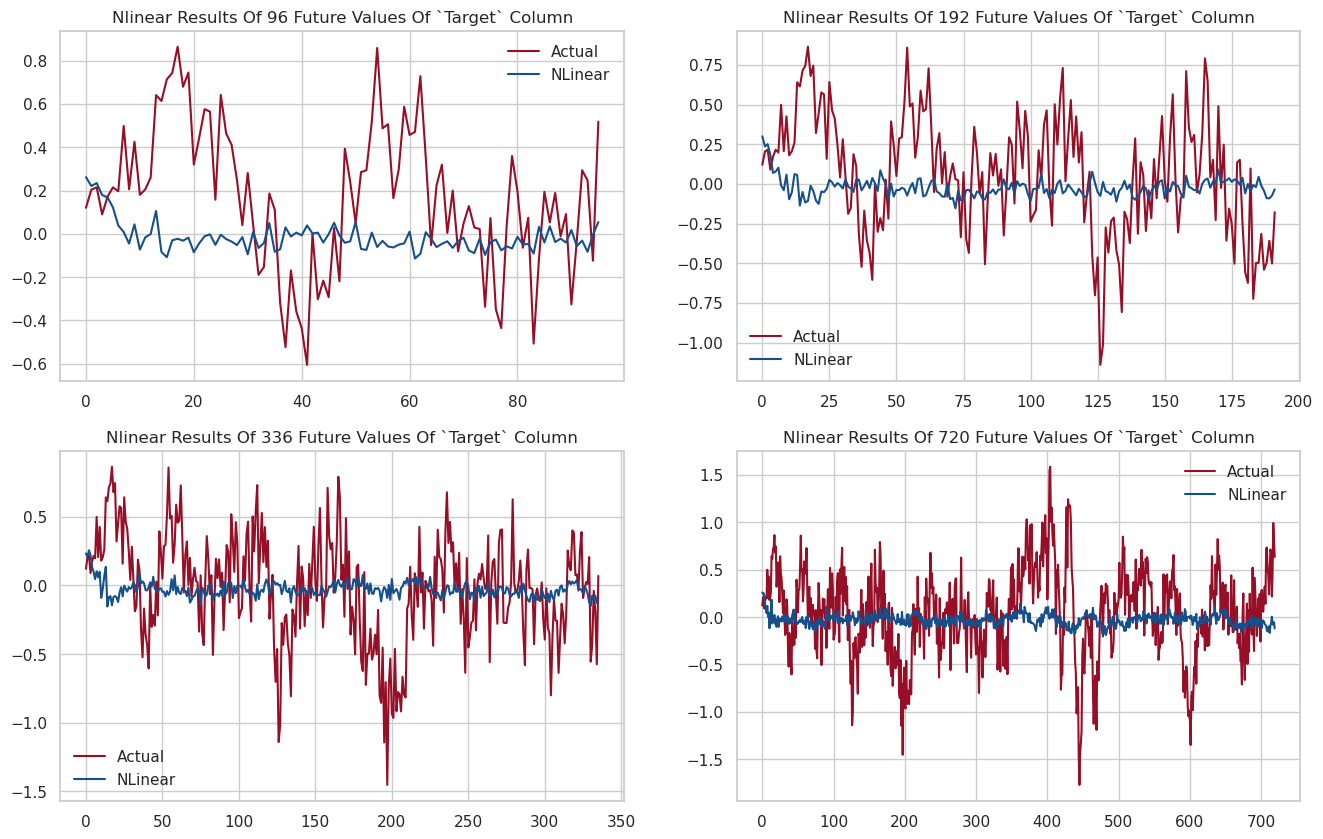

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate("NLinear", pred_len,ax, colors)

plt.show()

---
## Bitcoin - Evaluating Informer

---

informer_train_on_Bitcoin_96	: mae:0.42, mse:0.34, rmse:0.59, mape:1.62, mspe:864.93
informer_train_on_Bitcoin_192	: mae:0.42, mse:0.34, rmse:0.59, mape:1.46, mspe:412.14
informer_train_on_Bitcoin_336	: mae:0.42, mse:0.34, rmse:0.59, mape:1.42, mspe:364.67
informer_train_on_Bitcoin_720	: mae:0.42, mse:0.35, rmse:0.59, mape:1.66, mspe:1027.10


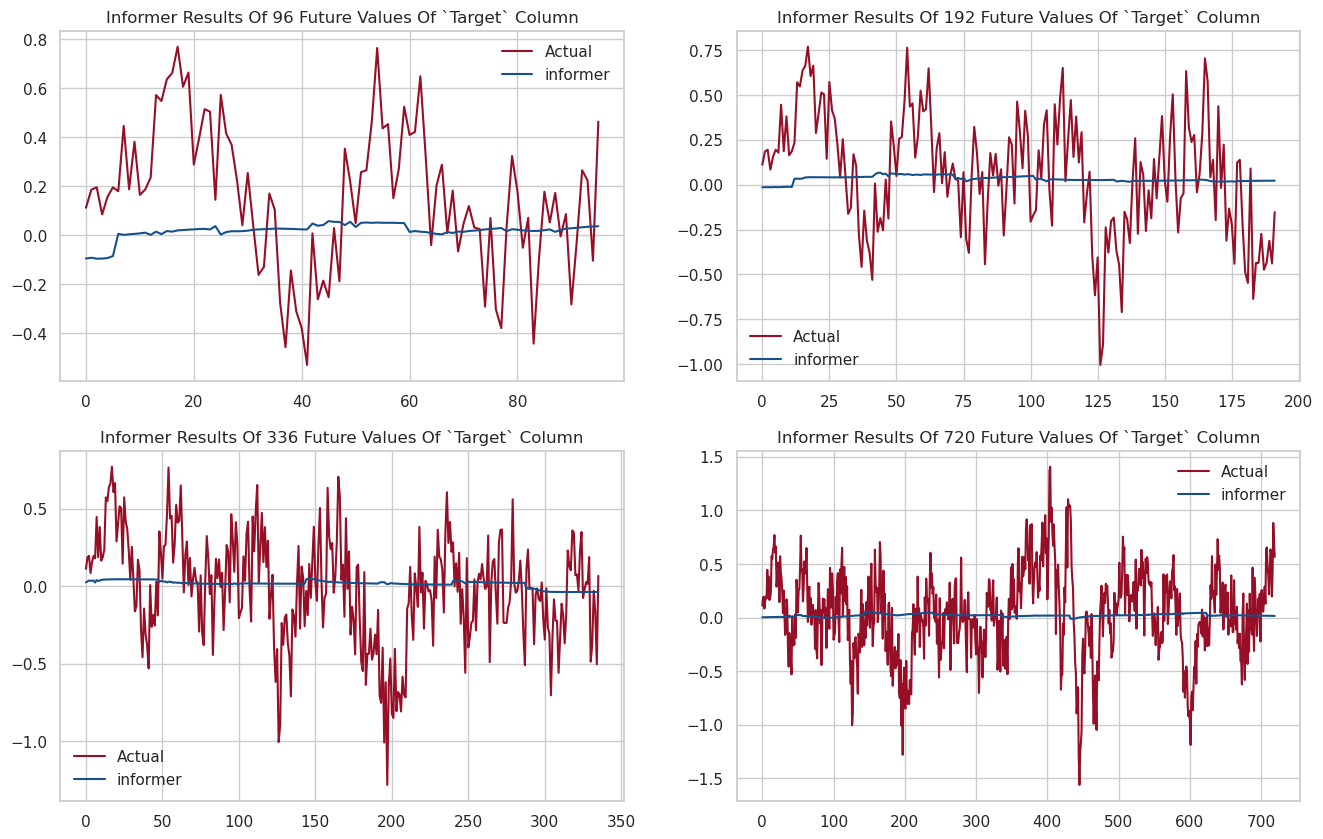

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate("informer", pred_len,ax, colors)

plt.show()

---
## Bitcoin - Evaluting FEDfromer

---

FEDformer_train_on_Bitcoin_96	: mae:1.39, mse:3.16, rmse:1.78, mape:31.84, mspe:1245519.50
FEDformer_train_on_Bitcoin_192	: mae:1.55, mse:3.79, rmse:1.95, mape:34.70, mspe:1438758.25
FEDformer_train_on_Bitcoin_336	: mae:1.57, mse:3.87, rmse:1.97, mape:34.67, mspe:1476521.12
FEDformer_train_on_Bitcoin_720	: mae:1.64, mse:4.21, rmse:2.05, mape:38.43, mspe:1740615.25


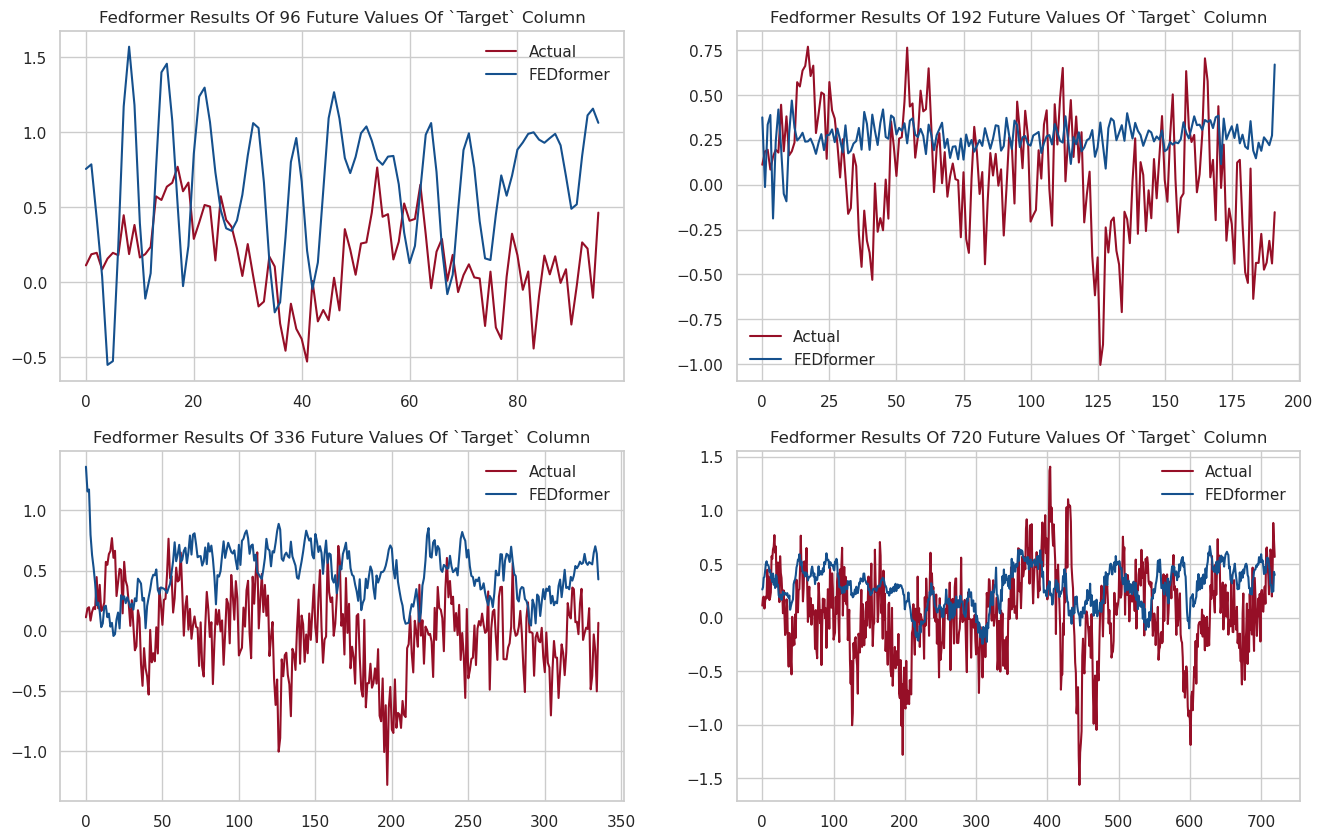

In [29]:
model_name = "FEDformer"
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate(model_name, pred_len, ax, colors)

plt.show()

---
## Bitcoin - Evaluting PathchTST

---

PatchTST_train_on_Bitcoin_96	: mae:0.42, mse:0.34, rmse:0.59, mape:1.97, mspe:1722.32
PatchTST_train_on_Bitcoin_192	: mae:0.42, mse:0.34, rmse:0.59, mape:1.94, mspe:1947.81
PatchTST_train_on_Bitcoin_336	: mae:0.42, mse:0.35, rmse:0.59, mape:1.99, mspe:1961.19
PatchTST_train_on_Bitcoin_720	: mae:0.42, mse:0.35, rmse:0.59, mape:1.70, mspe:994.00


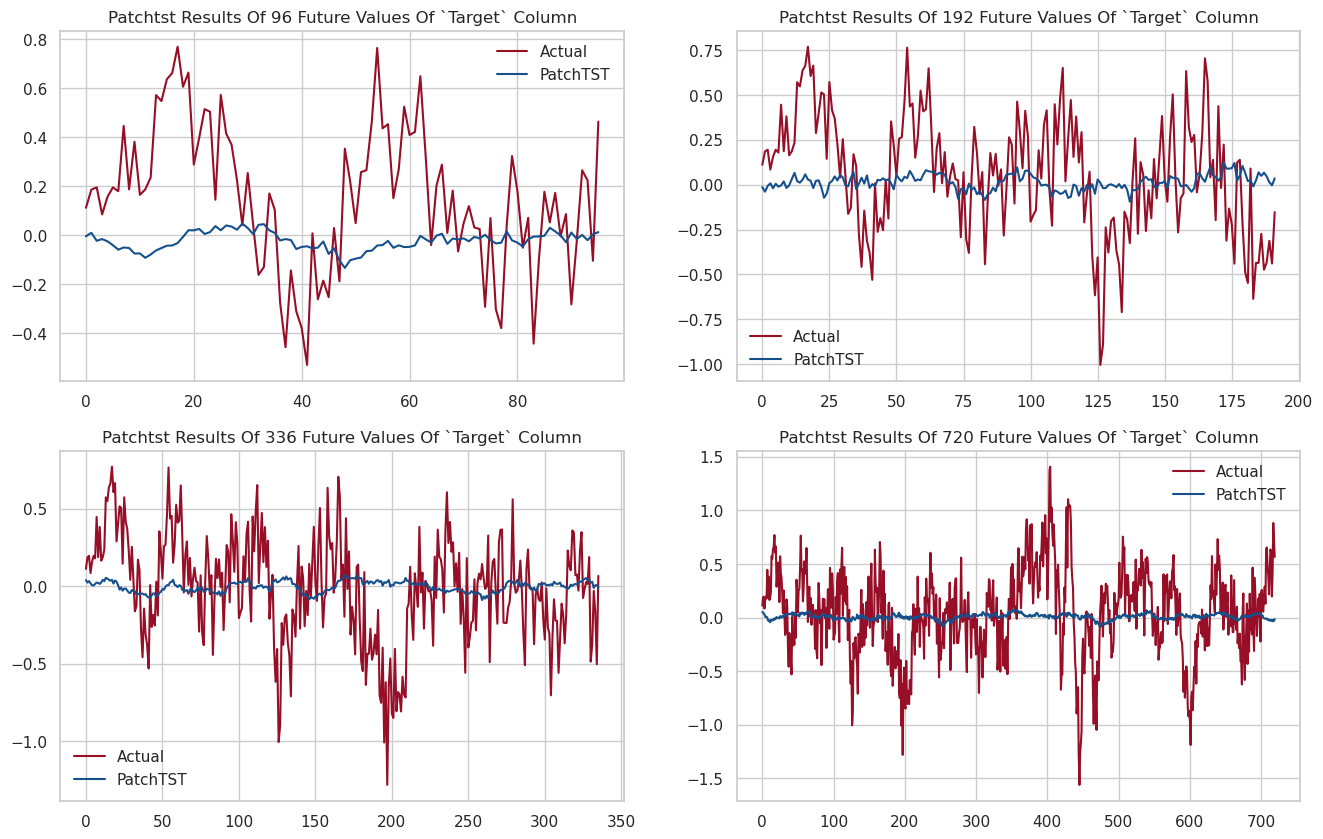

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
pred_lens = [96,192,336,720]

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate("PatchTST", pred_len,ax, colors)

plt.show()

In [38]:
InteractiveShell.ast_node_interactivity = 'last_expr'


plt.show()

PatchTST_train_on_Bitcoin_96_test	: mae:0.41, mse:0.34, rmse:0.58, mape:1.98, mspe:1795.32


PatchTST_train_on_Bitcoin_96_test	: mae:0.41, mse:0.34, rmse:0.58, mape:1.98, mspe:1795.32


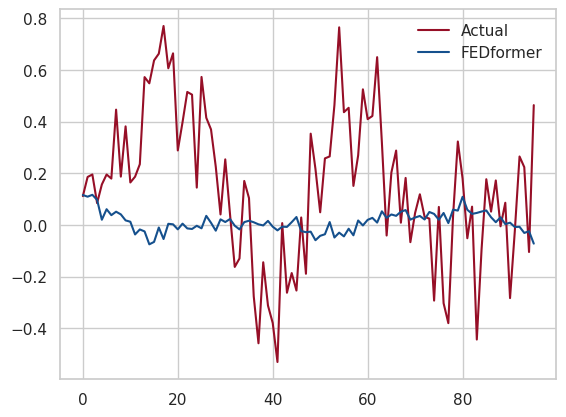

In [40]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
# pred_lens = [96,192,336,720]


setting = 'PatchTST_train_on_Bitcoin_96_test'
trues = np.load('./results/'+ setting +'/true.npy') # [samples, pred_len, dimensions]
preds = np.load('./results/'+ setting +'/pred.npy') # [samples, pred_len, dimensions]
mae, mse, rmse, mape, mspe = np.load('./results/'+ setting +'/metrics.npy', allow_pickle=True) 
#     print("Prediction labels shape: {}, Actual labels ahape:{}".format(preds.shape, trues.shape))
print(setting + '\t: mae:{:0.2f}, mse:{:0.2f}, rmse:{:0.2f}, mape:{:0.2f}, mspe:{:0.2f}'.format(mae, mse, rmse, mape, mspe))

for i, data in enumerate([trues[0,:,-1], preds[0,:,-1]]):
    sns.lineplot(x=range(len(data)), y=data, label=["Actual", model_name][i], color=colors[i])
#     ax.title(f"{model_name} results of {pred_len} future values of `Target` column".title())
#     ax.legend()